In [1]:
from models.utils import set_global_seed
set_global_seed(42)
from torchvision import transforms
from torchvision.datasets import FashionMNIST, CIFAR10, CIFAR100, MNIST
from models.cleaner import NoiseCleaner
from models.predictor import Predictor

# Instance Independent

In [7]:
train_dataset = FashionMNIST(root='data', train=True, download=True)
transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
noise_cleaner = NoiseCleaner(train_dataset, noise_type='iin', model_save_path="fmnist/resnet18/model_resnet18_fmnist_fold_{}.pth", folds_num=5, model='resnet18', train_noise_level=0.2, epochs_num=20, transform=transform)

TypeError: NoiseCleaner.__init__() got an unexpected keyword argument 'folds_num'

In [ ]:
noise_cleaner.clean()

Training fold 1/5...


Epoch 0/20:   0%|          | 0/20 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
clean_train_dataset = noise_cleaner.clean_dataset
test_dataset = FashionMNIST(root='data', train=False, download=False)
predictor = Predictor(train_dataset=clean_train_dataset, test_dataset=test_dataset, transform=transform, num_classes=10, model_type='resnet18', batch_size=400, num_epochs=50)

In [ ]:
predictor.train(10)

In [ ]:
predictor.evaluate()

Evaluating: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]

Test Accuracy: 92.33%


0.9233

# Instance Dependent

## FMnist

In [3]:
train_dataset = FashionMNIST(root='data', train=True, download=False)
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
augmented_transform = transforms.Compose([
                                # transforms.RandomCrop(size=32, padding=4),
                                # transforms.RandomHorizontalFlip(),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
noise_cleaner = NoiseCleaner(train_dataset, noise_type='idn', model_save_path="fmnist/resnet18/model_resnet18_fmnist_fold_{}.pth", 
                             inner_folds_num=10, outer_folds_num=10, model='wresnet50', train_noise_level=0.2, epochs_num=100, train_pairs=20000, 
                             val_pairs=10000, embedding_dimension=128, lr=1e-3, optimizer='Adam', patience=10, transform=transform,
                             weight_decay=0.0001, training_batch_size=1024, pre_trained=False, dropout_prob=0.2, contrastive_ratio=1,
                             distance_meter='euclidian', augmented_transform=augmented_transform, trainable=True, pair_validation=False,
                             label_smoothing=0.1, loss='ce')

Seed: 78


KeyboardInterrupt: 

handling big fold 1/10
number_of_pairs: 4309
Training fold 1/10...


Epoch 10/100:  11%|█         | 11/100 [04:45<38:29, 25.94s/it, val_loss=4.7, val_accuracy=10.6, train_loss=4.7, best_accuracy=10.9]

Early stopping triggered
Loading best model from checkpoint...


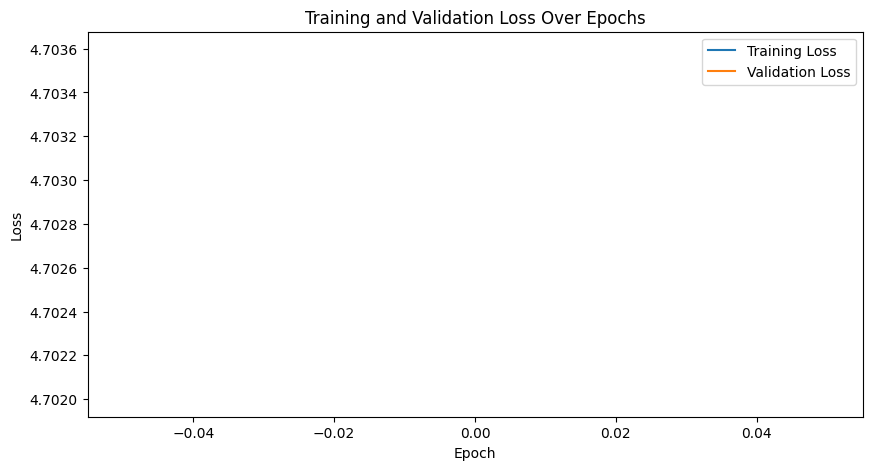

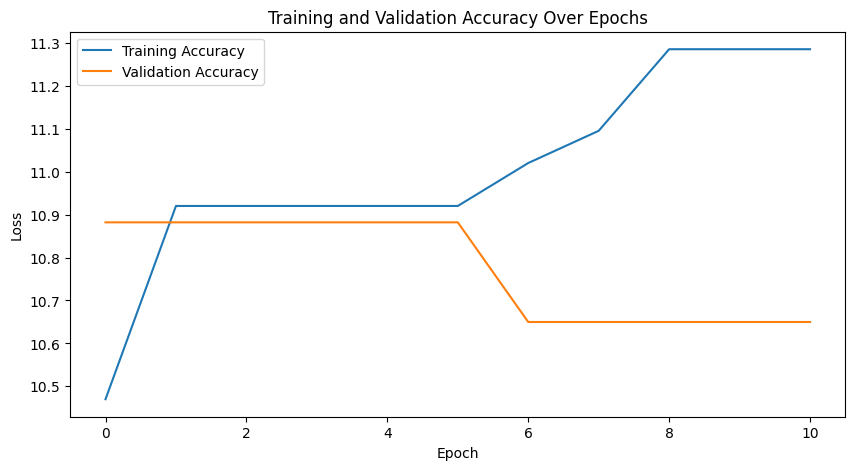

Extracting Embeddings: 100%|██████████| 485/485 [00:06<00:00, 69.79it/s]


Distance between embedding 6589 and 2885: 0.0031
Distance between embedding 6589 and 4016: 0.0037
Distance between embedding 6589 and 5862: 0.0039
Distance between embedding 6589 and 3761: 0.0016
Distance between embedding 6589 and 2201: 0.0011
Distance between embedding 6589 and 6468: 0.0009
Distance between embedding 6589 and 3726: 0.0013
Distance between embedding 6589 and 5161: 0.0011
Distance between embedding 6589 and 1572: 0.0013
Distance between embedding 6589 and 4632: 0.0019
Distance between embedding 6589 and 1639: 0.0010
Distance between embedding 6589 and 399: 0.0013
Distance between embedding 6589 and 1987: 0.0009
Distance between embedding 6589 and 7109: 0.0010
Distance between embedding 6589 and 5832: 0.0011
Distance between embedding 6589 and 6283: 0.0049
Distance between embedding 6589 and 6233: 0.0047
Distance between embedding 6589 and 354: 0.0022
Distance between embedding 6589 and 3924: 0.0028
Distance between embedding 2885 and 4016: 0.0023
Distance between embed

Testing: 100%|██████████| 485/485 [00:06<00:00, 75.06it/s]
/home/aref/.conda/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 10.88%
Test Precision: 0.01
Test Recall: 0.11
Test F1 Score: 0.02
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_1.pth
Finished training fold 1
Training fold 2/10...


Epoch 29/100:  29%|██▉       | 29/100 [12:49<31:24, 26.54s/it, val_loss=3.44, val_accuracy=63.5, train_loss=2.81, best_accuracy=66.8]


KeyboardInterrupt: 

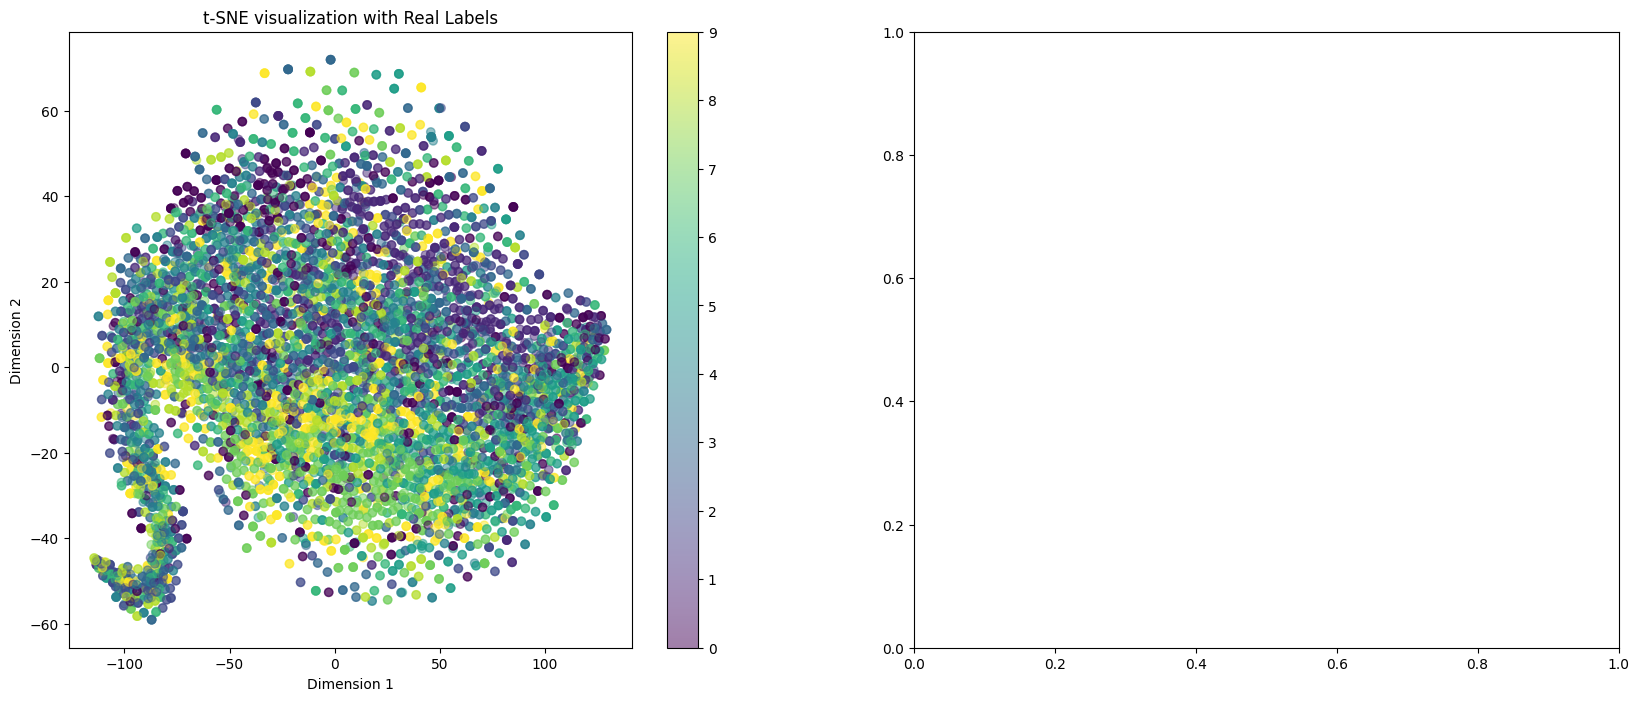

In [ ]:
noise_cleaner.clean()

In [ ]:
import models.predictor
import models
import importlib
importlib.reload(models)
from models import preact
importlib.reload(preact)
from models import predictor
importlib.reload(predictor)
from models.predictor import Predictor

In [ ]:
clean_train_dataset = noise_cleaner.clean_dataset
test_dataset = FashionMNIST(root='data', train=False, download=False)
predictor = Predictor(train_dataset=clean_train_dataset, test_dataset=test_dataset, transform=transform, num_classes=10, model_type='resnet18', batch_size=400)

In [ ]:
predictor.train(10)

Training Epoch 1/10: 100%|██████████| 113/113 [01:40<00:00,  1.12it/s]


Validation Accuracy: 93.46%
Epoch 1/10, Loss: 0.24129432162879844


Training Epoch 2/10: 100%|██████████| 113/113 [01:39<00:00,  1.13it/s]


Validation Accuracy: 96.31%
Epoch 2/10, Loss: 0.12274887458940523


Training Epoch 3/10: 100%|██████████| 113/113 [01:39<00:00,  1.13it/s]


Validation Accuracy: 97.07%
Epoch 3/10, Loss: 0.08064110191390578


Training Epoch 4/10: 100%|██████████| 113/113 [01:39<00:00,  1.14it/s]


Validation Accuracy: 96.81%
Epoch 4/10, Loss: 0.07340764353233101


Training Epoch 5/10: 100%|██████████| 113/113 [01:39<00:00,  1.14it/s]


Validation Accuracy: 96.51%
Epoch 5/10, Loss: 0.059963096196936294


Training Epoch 6/10: 100%|██████████| 113/113 [01:38<00:00,  1.15it/s]


Validation Accuracy: 97.89%
Epoch 6/10, Loss: 0.0528966288980657


Training Epoch 7/10: 100%|██████████| 113/113 [01:40<00:00,  1.13it/s]


Validation Accuracy: 97.85%
Epoch 7/10, Loss: 0.03885995962582858


Training Epoch 8/10: 100%|██████████| 113/113 [01:40<00:00,  1.13it/s]


Validation Accuracy: 97.95%
Epoch 8/10, Loss: 0.03452066272760915


Training Epoch 9/10: 100%|██████████| 113/113 [01:40<00:00,  1.12it/s]


Validation Accuracy: 98.30%
Epoch 9/10, Loss: 0.030963845262551203


Training Epoch 10/10: 100%|██████████| 113/113 [01:39<00:00,  1.13it/s]


Validation Accuracy: 98.22%
Epoch 10/10, Loss: 0.02610123477282777


In [ ]:
predictor.evaluate()

Evaluating: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]

Test Accuracy: 90.21%


0.9021

## CIFAR 10 - 20

In [ ]:
train_dataset = CIFAR10(root='data', train=True, download=True)
transform = transforms.Compose([
                                # transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

augmented_transform = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

new_augmented_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),        # Random rotation within 15 degrees
    transforms.RandomHorizontalFlip(p=0.5),      # Random horizontal flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Width and height shift
    transforms.RandomResizedCrop(size=32, scale=(0.9, 1.0)),  # Zoom-like effect
    transforms.ToTensor(),                        # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize
])

noise_cleaner = NoiseCleaner(train_dataset, noise_type='idn', model_save_path="cifar10/resnet50/model_resnet50_cifar10_fold_{}.pth", 
                             inner_folds_num=10, outer_folds_num=10, model='resnet50', train_noise_level=0.2, epochs_num=1000, train_pairs=200000, 
                             val_pairs=20000, embedding_dimension=64, lr=5e-5, optimizer='Adam', patience=8, transform=transform,
                             weight_decay=5e-4, training_batch_size=2048, pre_trained=True, dropout_prob=0.5, contrastive_ratio=1,
                             distance_meter='euclidian', augmented_transform=augmented_transform, trainable=True, pair_validation=False,
                             label_smoothing=0.1, loss='ce', margin=2, freeze_epoch=None, noisy_indices_path='cifar10/resnet50/fold{}_noisy_indices.csv',
                             prediction_path='cifar10/resnet50/fold{}_analysis.csv', mistakes_count=10, relabeling_range=range(6, 11))

Files already downloaded and verified
Seed: 51
noise count: 10208 out of 50000 data


In [3]:
noise_cleaner.save_noisy_dataset('cleaned', 'dirty')

100%|██████████| 50000/50000 [00:03<00:00, 12964.02it/s]

Noisy dataset saved to cleaned/dirty.pkl


In [5]:
noise_cleaner.clean()

Skipping outer fold 1 with results:
80.21077283372365% accuracy in 854 data
Loaded 854 noisy indices from cifar10/resnet50/fold1_noisy_indices.csv
Skipping outer fold 2 with results:
79.53488372093022% accuracy in 860 data
Loaded 860 noisy indices from cifar10/resnet50/fold2_noisy_indices.csv
Skipping outer fold 3 with results:
78.55504587155964% accuracy in 872 data
Loaded 872 noisy indices from cifar10/resnet50/fold3_noisy_indices.csv
Skipping outer fold 4 with results:
80.02466091245375% accuracy in 811 data
Loaded 811 noisy indices from cifar10/resnet50/fold4_noisy_indices.csv
Skipping outer fold 5 with results:
80.62770562770562% accuracy in 924 data
Loaded 924 noisy indices from cifar10/resnet50/fold5_noisy_indices.csv
Skipping outer fold 6 with results:
77.0011273957159% accuracy in 887 data
Loaded 887 noisy indices from cifar10/resnet50/fold6_noisy_indices.csv
Skipping outer fold 7 with results:
79.57992998833139% accuracy in 857 data
Loaded 857 noisy indices from cifar10/resne

              precision    recall  f1-score   support

       Clean     0.9569    0.9248    0.9406     39792
       Noisy     0.7408    0.8375    0.7862     10208

    accuracy                         0.9070     50000
   macro avg     0.8488    0.8811    0.8634     50000
weighted avg     0.9127    0.9070    0.9090     50000



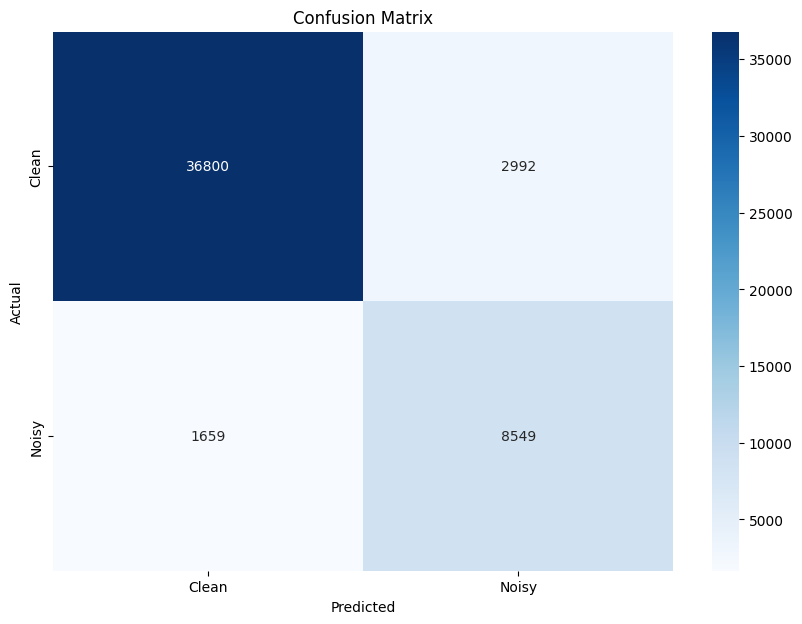

In [9]:
noise_cleaner.report(mistakes_count=9)

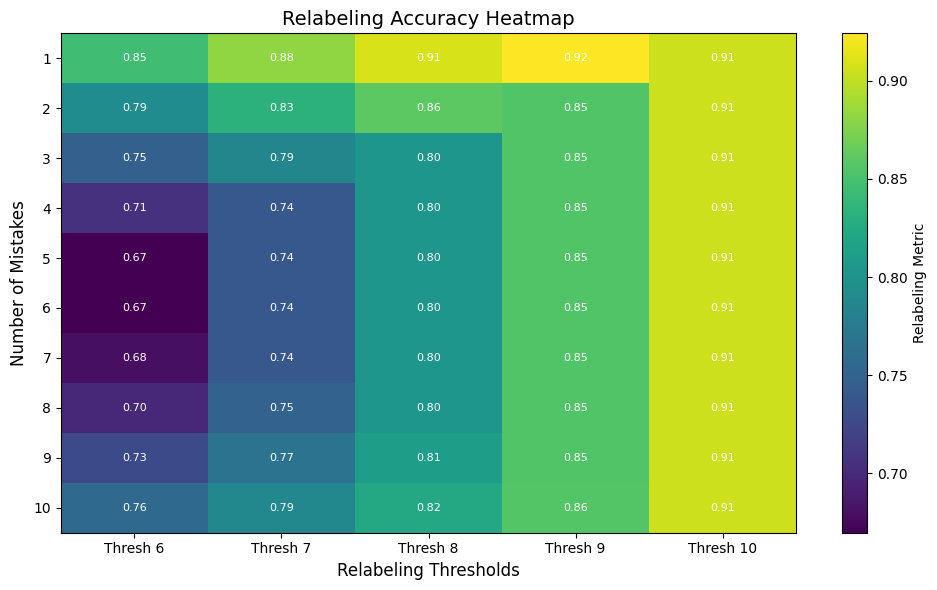

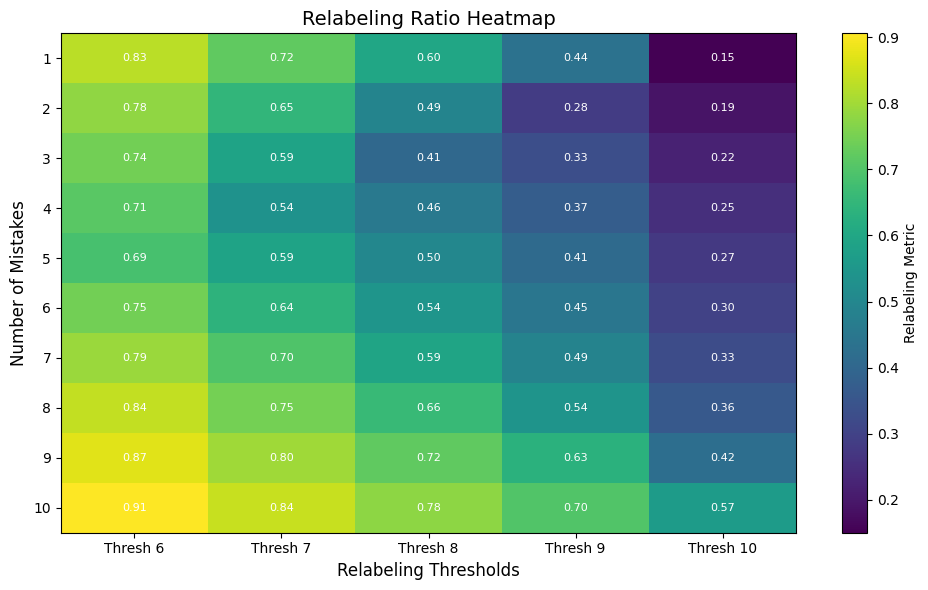

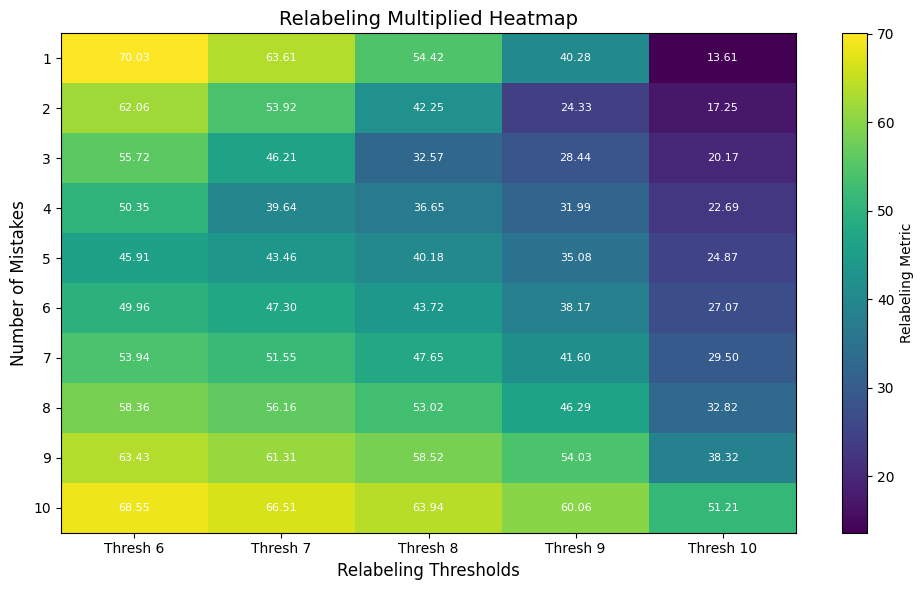

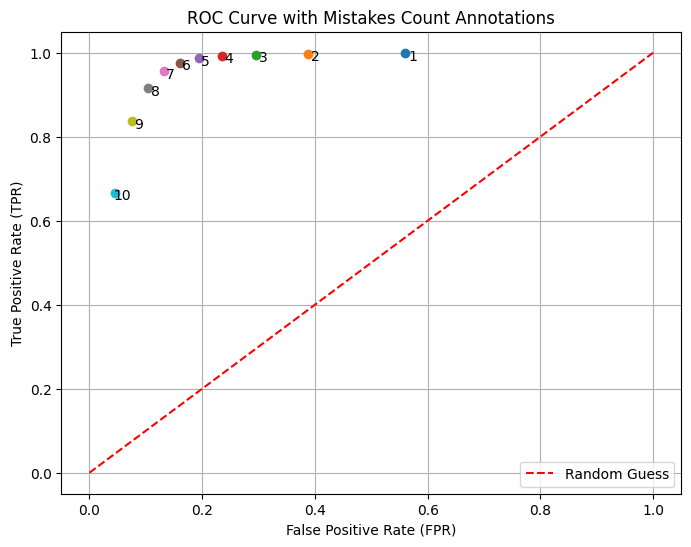

Area Under the Curve (AUC): 0.49907322987450103


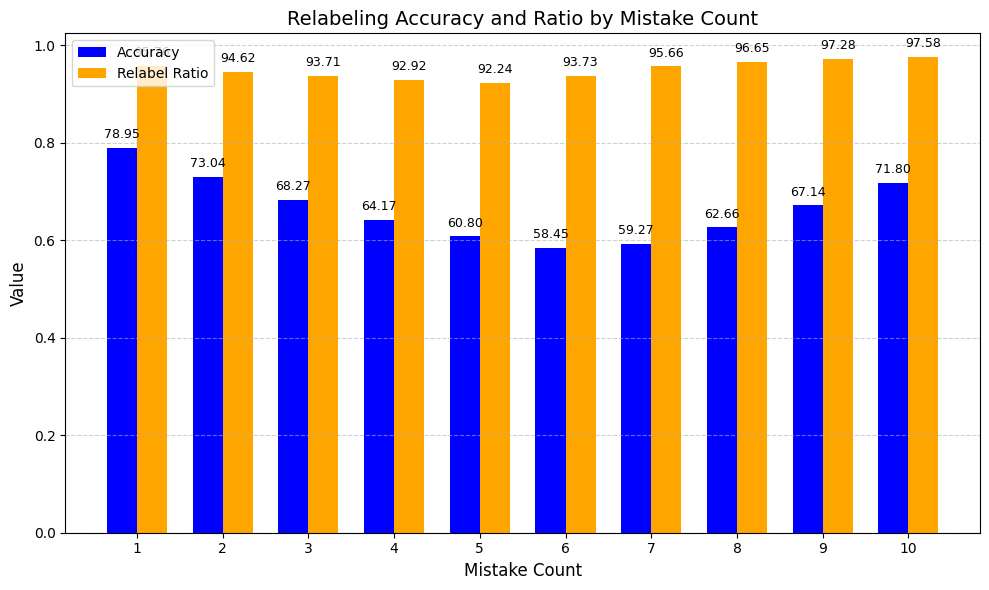

In [4]:
noise_cleaner.analyze()

Files already downloaded and verified
              precision    recall  f1-score   support

       Clean     0.9569    0.9248    0.9406     39792
       Noisy     0.7408    0.8375    0.7862     10208

    accuracy                         0.9070     50000
   macro avg     0.8488    0.8811    0.8634     50000
weighted avg     0.9127    0.9070    0.9090     50000



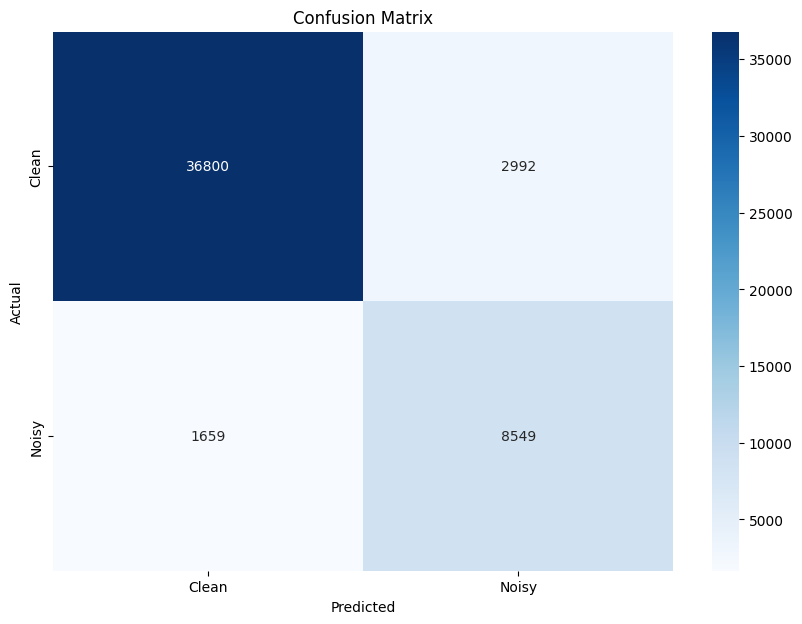

              precision    recall  f1-score   support

       Clean     0.8577    0.9343    0.8944     39792
       Noisy     0.6074    0.3960    0.4794     10208

    accuracy                         0.8244     50000
   macro avg     0.7326    0.6651    0.6869     50000
weighted avg     0.8066    0.8244    0.8097     50000



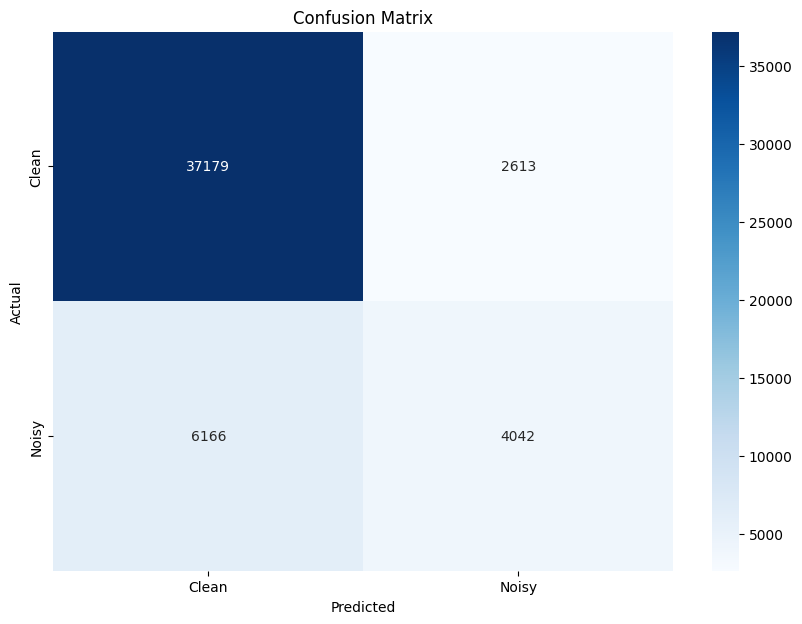

6655 removed from dataset and 4886 relabled
4.90% noise remained in 43345 data


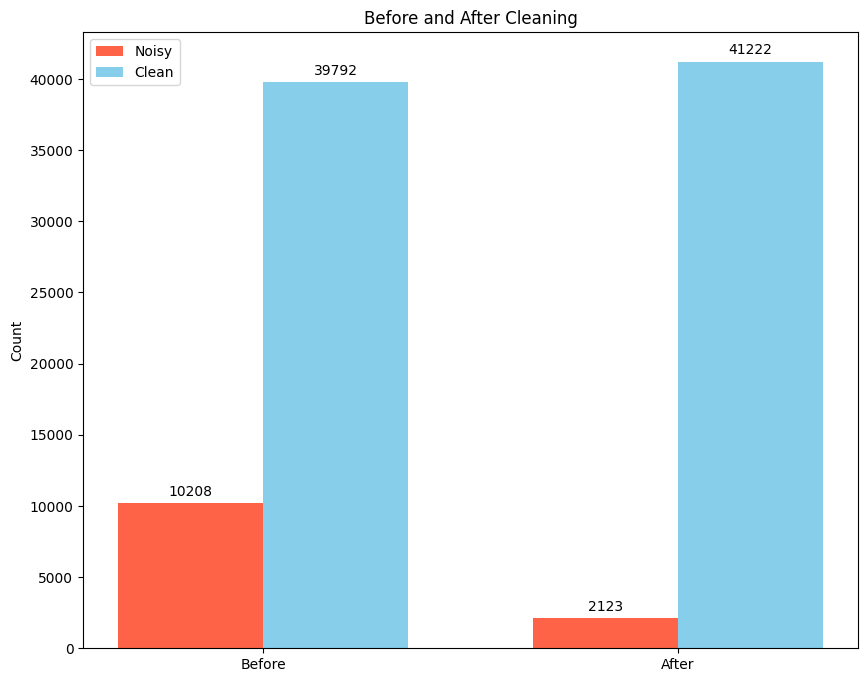

100%|██████████| 43345/43345 [05:45<00:00, 125.37it/s] 


Cleaned dataset saved to cleaned/Advanced-CIFAR10.pkl


In [4]:
dataset = CIFAR10(root='data', train=True, download=True)
manual_cleaned = noise_cleaner.advanced_clean(dataset=dataset, mistakes_count=9, relabel_threshold=10)
noise_cleaner.save_cleaned_cifar_dataset_manual(manual_cleaned, 'cleaned', 'Advanced-CIFAR10')

In [6]:
noise_cleaner.save_cleaned_cifar_dataset('cleaned', 'CIFAR10')

100%|██████████| 41150/41150 [00:01<00:00, 21517.98it/s]

Cleaned dataset saved to cleaned/CIFAR10.pkl


## CIFAR10 - 30

In [2]:
train_dataset = CIFAR10(root='data', train=True, download=True)
transform = transforms.Compose([
                                # transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

augmented_transform = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

new_augmented_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),        # Random rotation within 15 degrees
    transforms.RandomHorizontalFlip(p=0.5),      # Random horizontal flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Width and height shift
    transforms.RandomResizedCrop(size=32, scale=(0.9, 1.0)),  # Zoom-like effect
    transforms.ToTensor(),                        # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize
])

noise_cleaner = NoiseCleaner(train_dataset, noise_type='idn', model_save_path="cifar10(30)/resnet50/model_resnet50_cifar10_fold_{}.pth", 
                             inner_folds_num=10, outer_folds_num=10, model='resnet50', train_noise_level=0.3, epochs_num=1000, train_pairs=200000, 
                             val_pairs=20000, embedding_dimension=64, lr=5e-5, optimizer='Adam', patience=10, transform=transform,
                             weight_decay=5e-4, training_batch_size=2048, pre_trained=True, dropout_prob=0.5, contrastive_ratio=1,
                             distance_meter='euclidian', augmented_transform=augmented_transform, trainable=True, pair_validation=False,
                             label_smoothing=0.1, loss='ce', margin=2, freeze_epoch=None, noisy_indices_path='cifar10(30)/resnet50/fold{}_noisy_indices.csv',
                             prediction_path='cifar10(30)/resnet50/fold{}_analysis.csv', mistakes_count=10, relabeling_range=range(6, 11))

Files already downloaded and verified
Seed: 51
noise count: 14976 out of 50000 data


In [3]:
noise_cleaner.clean()

Skipping outer fold 1 with results:
72.09847596717468% accuracy in 853 data
Loaded 853 noisy indices from cifar10(30)/resnet50/fold1_noisy_indices.csv
Skipping outer fold 2 with results:
74.22434367541766% accuracy in 838 data
Loaded 838 noisy indices from cifar10(30)/resnet50/fold2_noisy_indices.csv
Skipping outer fold 3 with results:
74.74048442906575% accuracy in 867 data
Loaded 867 noisy indices from cifar10(30)/resnet50/fold3_noisy_indices.csv
Skipping outer fold 4 with results:
78.2668500687758% accuracy in 727 data
Loaded 727 noisy indices from cifar10(30)/resnet50/fold4_noisy_indices.csv
Skipping outer fold 5 with results:
74.47306791569088% accuracy in 854 data
Loaded 854 noisy indices from cifar10(30)/resnet50/fold5_noisy_indices.csv
Skipping outer fold 6 with results:
77.1604938271605% accuracy in 810 data
Loaded 810 noisy indices from cifar10(30)/resnet50/fold6_noisy_indices.csv
Skipping outer fold 7 with results:
76.58371040723982% accuracy in 884 data
Loaded 884 noisy ind

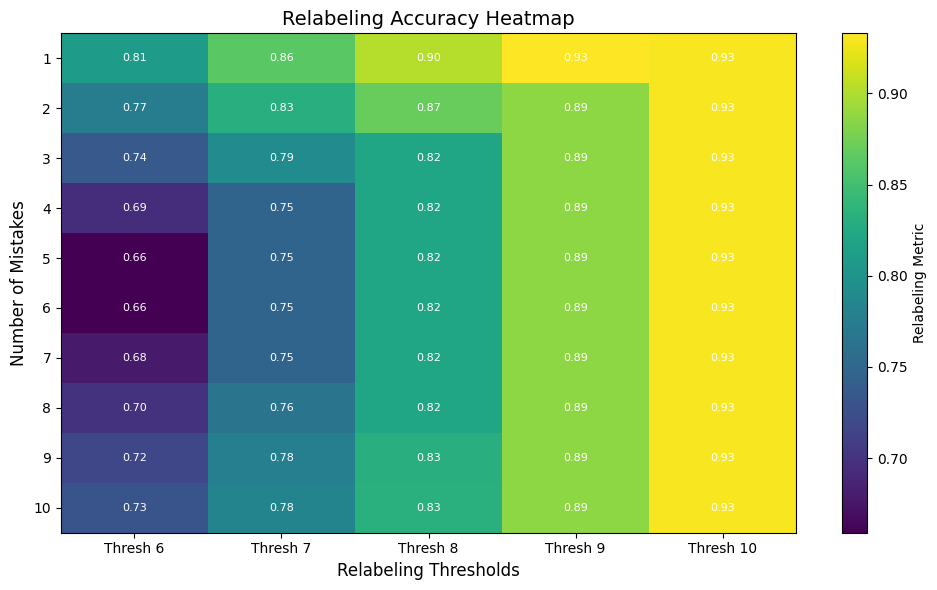

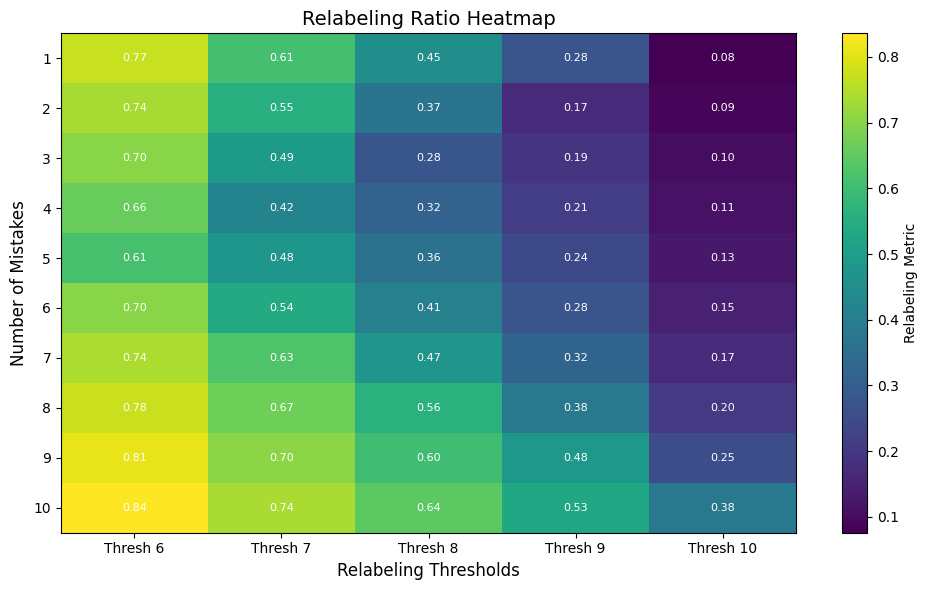

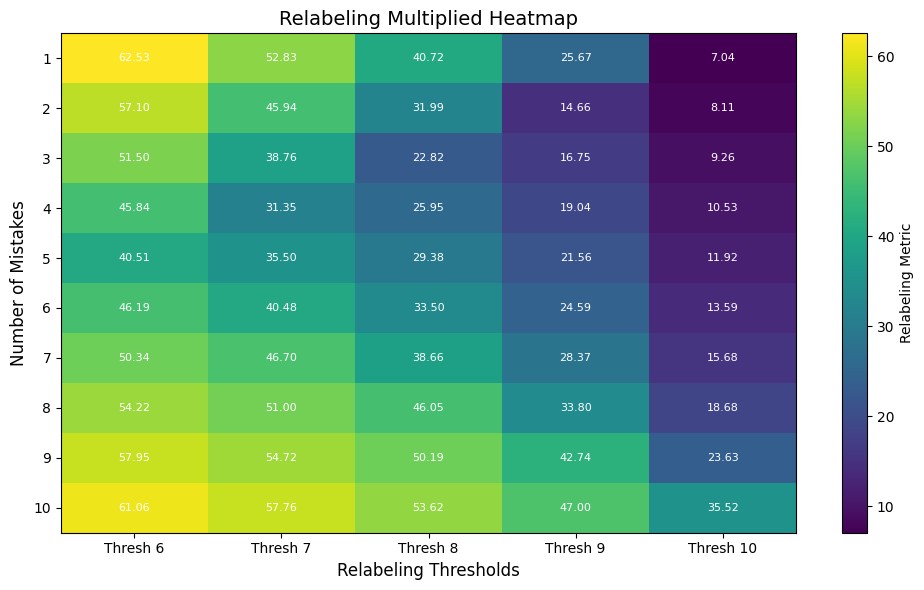

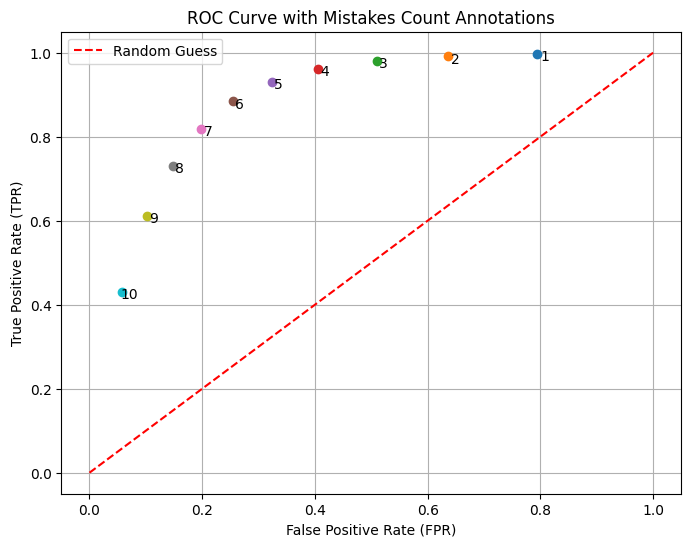

Area Under the Curve (AUC): 0.6646810900562569


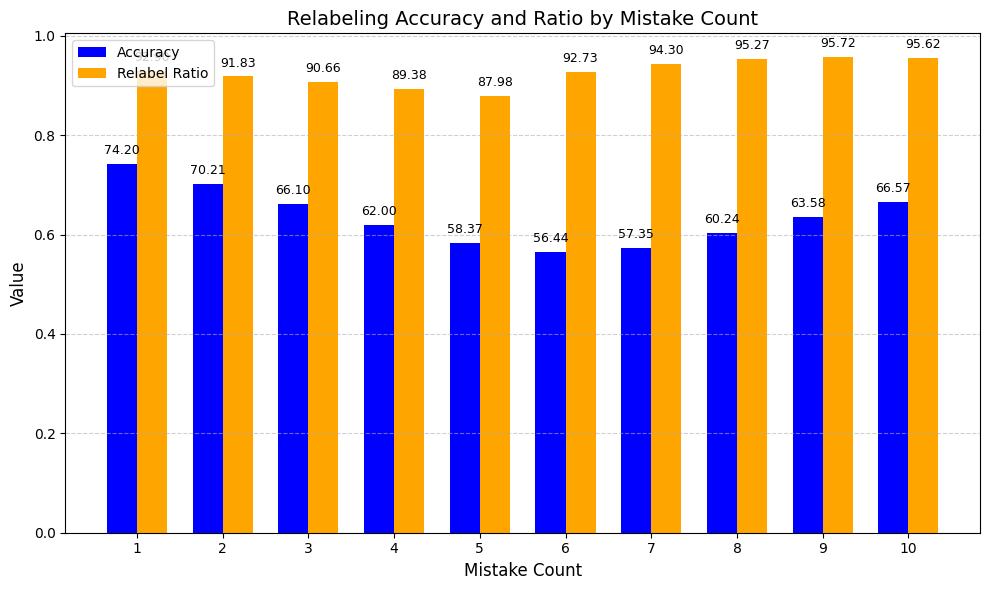

In [4]:
noise_cleaner.analyze()

Files already downloaded and verified
              precision    recall  f1-score   support

       Clean     0.9119    0.8018    0.8533     35024
       Noisy     0.6386    0.8188    0.7176     14976

    accuracy                         0.8069     50000
   macro avg     0.7752    0.8103    0.7854     50000
weighted avg     0.8300    0.8069    0.8127     50000



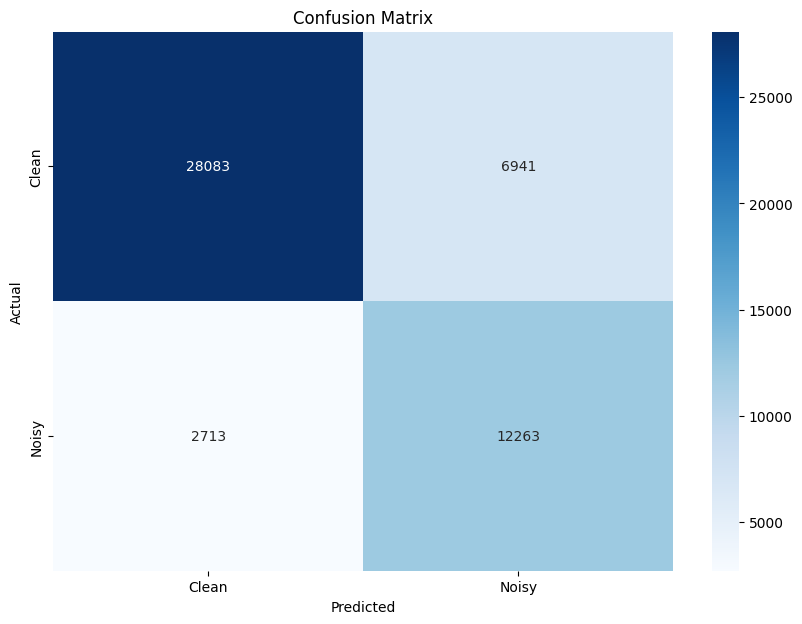

              precision    recall  f1-score   support

       Clean     0.7380    0.8395    0.7855     35024
       Noisy     0.4467    0.3030    0.3610     14976

    accuracy                         0.6788     50000
   macro avg     0.5923    0.5712    0.5733     50000
weighted avg     0.6507    0.6788    0.6584     50000



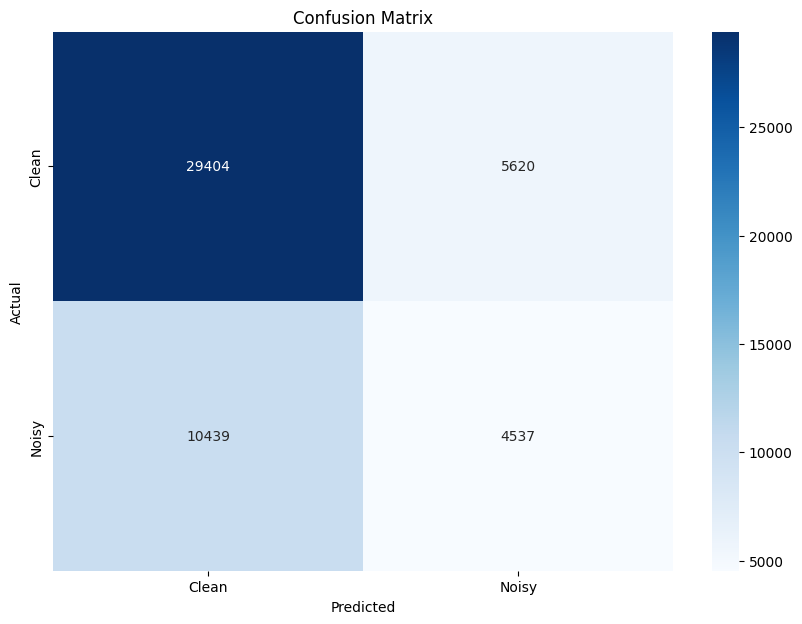

10157 removed from dataset and 9047 relabled
10.88% noise remained in 39843 data


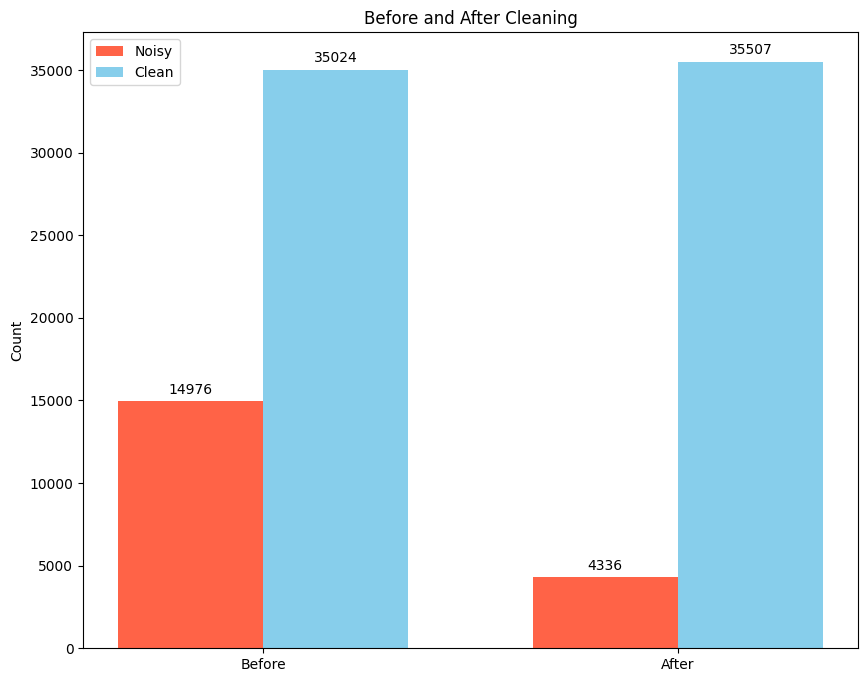

100%|██████████| 39843/39843 [00:01<00:00, 20965.34it/s]

Cleaned dataset saved to cleaned/Advanced-CIFAR10-30.pkl


In [ ]:
dataset = CIFAR10(root='data', train=True, download=True)
manual_cleaned = noise_cleaner.advanced_clean(dataset=dataset, mistakes_count=7, relabel_threshold=8)
noise_cleaner.save_cleaned_cifar_dataset_manual(manual_cleaned, 'cleaned', 'Advanced-CIFAR10-30')

## CIFAR10 - 40

In [2]:
train_dataset = CIFAR10(root='data', train=True, download=True)
transform = transforms.Compose([
                                # transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

augmented_transform = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

new_augmented_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),        # Random rotation within 15 degrees
    transforms.RandomHorizontalFlip(p=0.5),      # Random horizontal flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Width and height shift
    transforms.RandomResizedCrop(size=32, scale=(0.9, 1.0)),  # Zoom-like effect
    transforms.ToTensor(),                        # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize
])

noise_cleaner = NoiseCleaner(train_dataset, noise_type='idn', model_save_path="cifar10(40)/resnet50/model_resnet50_cifar10_fold_{}.pth", 
                             inner_folds_num=10, outer_folds_num=10, model='resnet50', train_noise_level=0.4, epochs_num=1000, train_pairs=200000, 
                             val_pairs=20000, embedding_dimension=64, lr=5e-5, optimizer='Adam', patience=15, transform=transform,
                             weight_decay=5e-4, training_batch_size=2048, pre_trained=True, dropout_prob=0.5, contrastive_ratio=1,
                             distance_meter='euclidian', augmented_transform=new_augmented_transform, trainable=True, pair_validation=False,
                             label_smoothing=0.1, loss='ce', margin=2, freeze_epoch=None, noisy_indices_path='cifar10(40)/resnet50/fold{}_noisy_indices.csv',
                             prediction_path='cifar10(40)/resnet50/fold{}_analysis.csv', mistakes_count=10, relabeling_range=range(6, 11))

Files already downloaded and verified
Seed: 51
noise count: 19803 out of 50000 data


In [3]:
noise_cleaner.clean()

Skipping outer fold 1 with results:
70.13729977116705% accuracy in 874 data
Loaded 874 noisy indices from cifar10(40)/resnet50/fold1_noisy_indices.csv
Skipping outer fold 2 with results:
63.282937365010795% accuracy in 926 data
Loaded 926 noisy indices from cifar10(40)/resnet50/fold2_noisy_indices.csv
Skipping outer fold 3 with results:
69.01408450704226% accuracy in 923 data
Loaded 923 noisy indices from cifar10(40)/resnet50/fold3_noisy_indices.csv
Skipping outer fold 4 with results:
71.32947976878613% accuracy in 865 data
Loaded 865 noisy indices from cifar10(40)/resnet50/fold4_noisy_indices.csv
Skipping outer fold 5 with results:
67.70114942528735% accuracy in 870 data
Loaded 870 noisy indices from cifar10(40)/resnet50/fold5_noisy_indices.csv
Skipping outer fold 6 with results:
63.24884792626728% accuracy in 868 data
Loaded 868 noisy indices from cifar10(40)/resnet50/fold6_noisy_indices.csv
Skipping outer fold 7 with results:
68.40148698884758% accuracy in 807 data
Loaded 807 noisy 

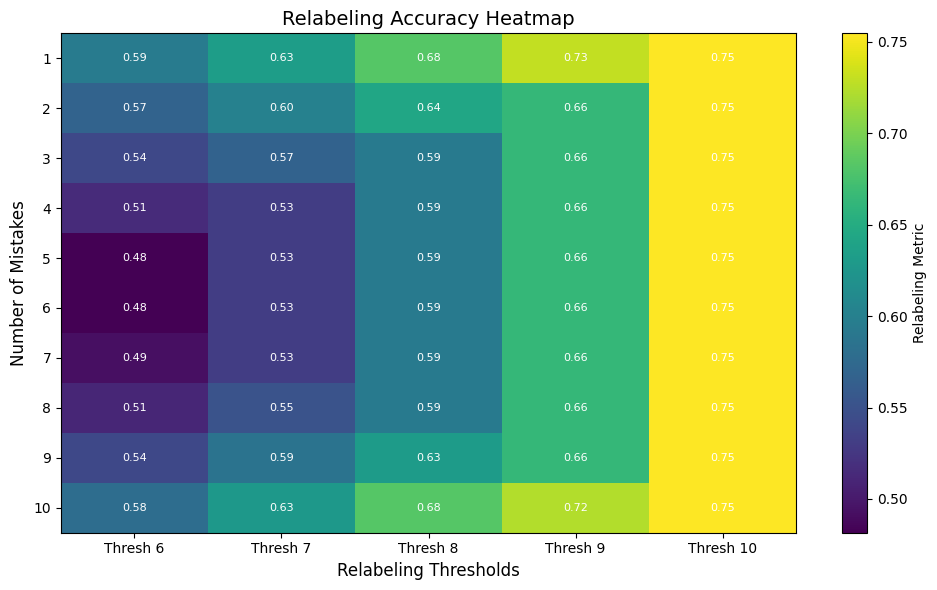

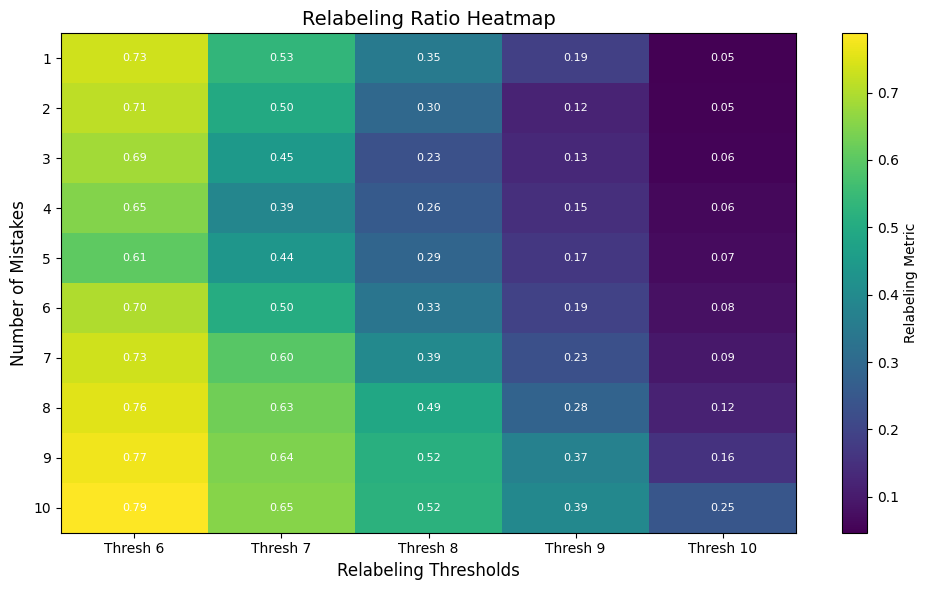

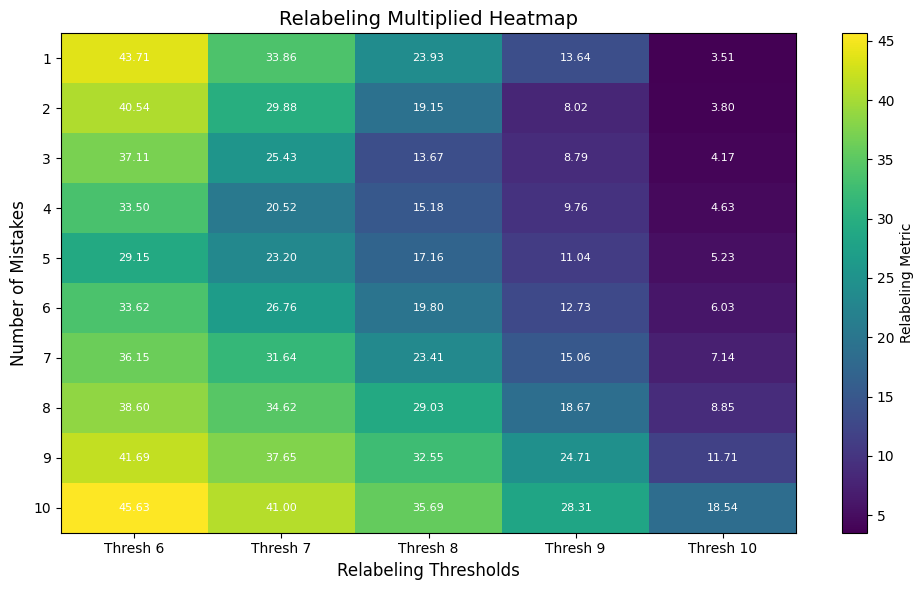

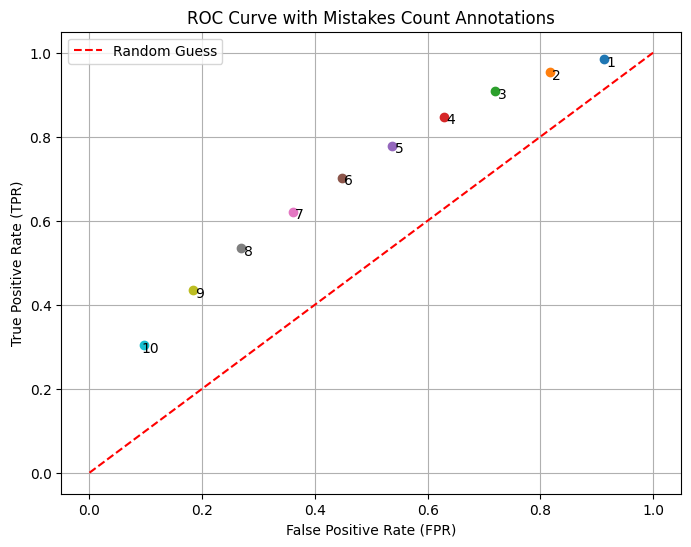

Area Under the Curve (AUC): 0.589056895488616


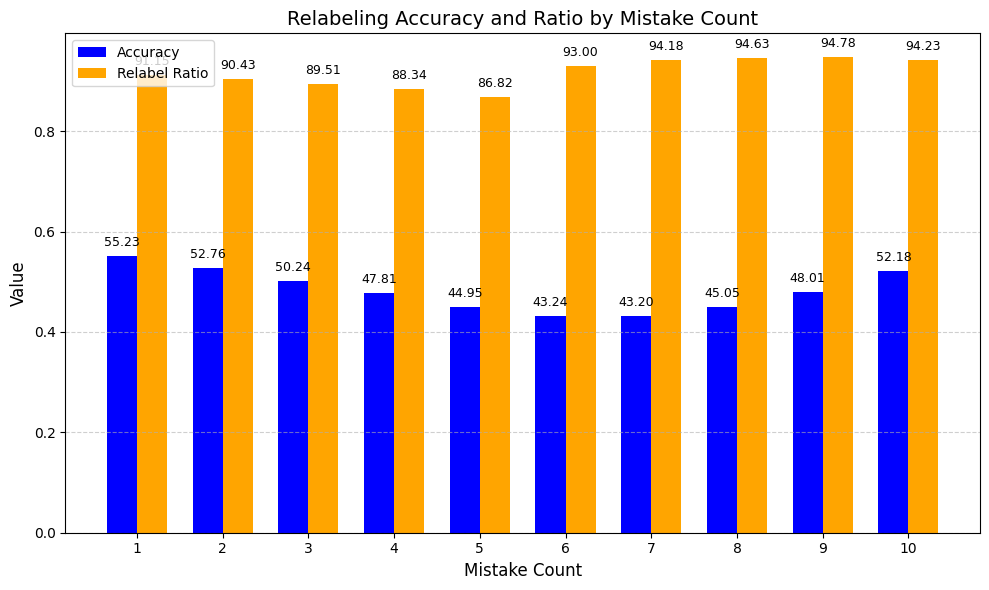

In [4]:
noise_cleaner.analyze()

Files already downloaded and verified
              precision    recall  f1-score   support

       Clean     0.7206    0.6397    0.6777     30197
       Noisy     0.5309    0.6217    0.5727     19803

    accuracy                         0.6326     50000
   macro avg     0.6257    0.6307    0.6252     50000
weighted avg     0.6454    0.6326    0.6361     50000



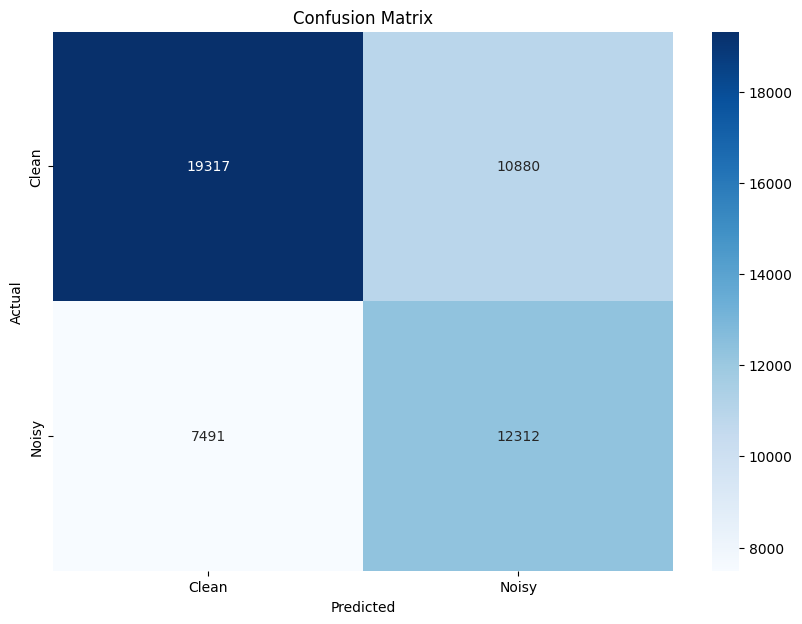

              precision    recall  f1-score   support

       Clean     0.6524    0.6929    0.6720     30197
       Noisy     0.4827    0.4371    0.4588     19803

    accuracy                         0.5916     50000
   macro avg     0.5676    0.5650    0.5654     50000
weighted avg     0.5852    0.5916    0.5876     50000



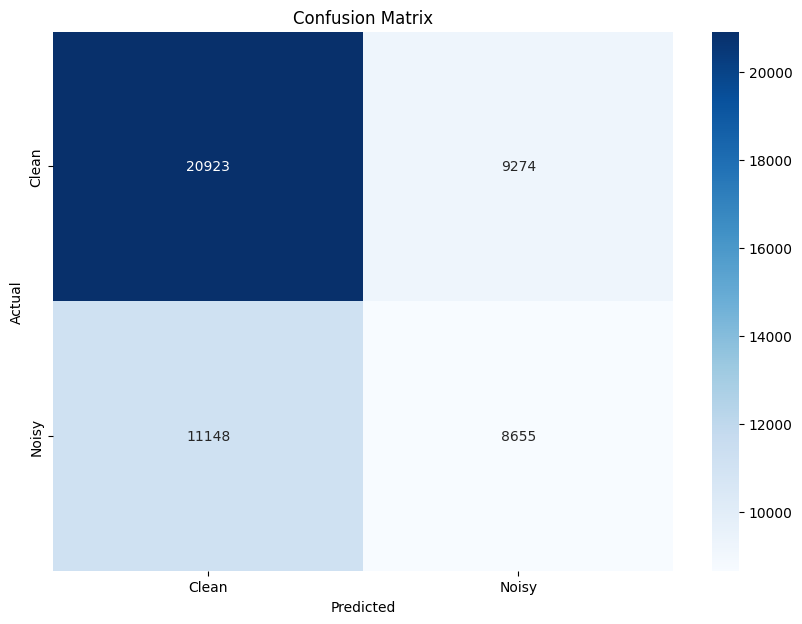

17929 removed from dataset and 5263 relabled
28.88% noise remained in 32071 data


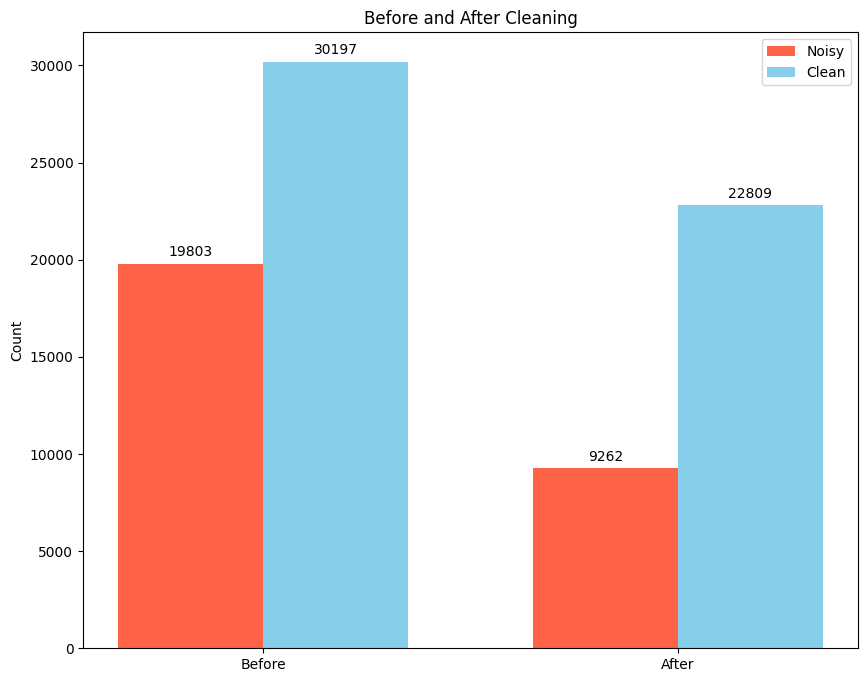

100%|██████████| 32071/32071 [00:01<00:00, 20518.49it/s]

Cleaned dataset saved to cleaned/Advanced-CIFAR10-40.pkl


In [9]:
dataset = CIFAR10(root='data', train=True, download=True)
manual_cleaned = noise_cleaner.advanced_clean(dataset=dataset, mistakes_count=7, relabel_threshold=9)
noise_cleaner.save_cleaned_cifar_dataset_manual(manual_cleaned, 'cleaned', 'Advanced-CIFAR10-40')

## CIFAR 100 - 20

In [2]:
train_dataset = CIFAR100(root='data', train=True, download=True)
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])])

augmented_transform = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
])

new_augmented_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),              # Random crop with 4-pixel padding
    transforms.RandomHorizontalFlip(),                 # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Optional color jitter
    transforms.RandAugment(num_ops=2, magnitude=9),      # Advanced policy: RandAugment
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762]) # Normalize
])

noise_cleaner = NoiseCleaner(train_dataset, noise_type='idn', model_save_path="cifar100(20)/resnet50/model_resnet50_cifar10_fold_{}.pth", 
                             inner_folds_num=15, outer_folds_num=15, model='resnet50', train_noise_level=0.2, epochs_num=1000, train_pairs=300000, 
                             val_pairs=30000, embedding_dimension=64, lr=5e-5, optimizer='Adam', patience=20, transform=transform,
                             weight_decay=5e-4, training_batch_size=2048, pre_trained=True, dropout_prob=0.4, contrastive_ratio=1,
                             distance_meter='euclidian', augmented_transform=new_augmented_transform, trainable=True, pair_validation=False,
                             label_smoothing=0.1, loss='ce', margin=2, freeze_epoch=None, noisy_indices_path='cifar100(20)/resnet50/fold{}_noisy_indices.csv',
                             prediction_path='cifar100(20)/resnet50/fold{}_analysis.csv', mistakes_count=10, relabeling_range=range(6, 11),
                             num_class=100)

Files already downloaded and verified
Seed: 51


/home/aref/projects/SiameseNoiseDetection/models/predefined.py:89: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /build/python-pytorch/src/pytorch-rocm/aten/src/ATen/Context.cpp:310.)
  A = x.contiguous().view(1, -1).mm(W[int(y)]).squeeze(0)


noise count: 10216 out of 50000 data


Skipping outer fold 1 with results:
39.96350364963504% accuracy in 1644 data
Loaded 1644 noisy indices from cifar100(20)/resnet50/fold1_noisy_indices.csv
handling big fold 2/15
number_of_pairs: 2394
Training fold 1/15...


Epoch 41/1000:   4%|▍         | 42/1000 [1:47:13<40:45:38, 153.17s/it, val_loss=8.15, val_contrastive=1.63, val_accuracy=46.3, train_loss=5.15, train_contrastive=1.95, best_accuracy=48.1, best_loss=8.15]


Early stopping triggered
Loading best model from checkpoint...


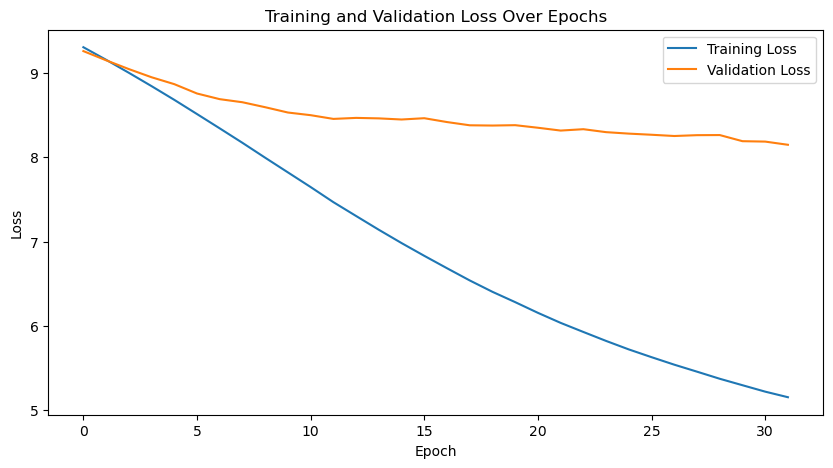

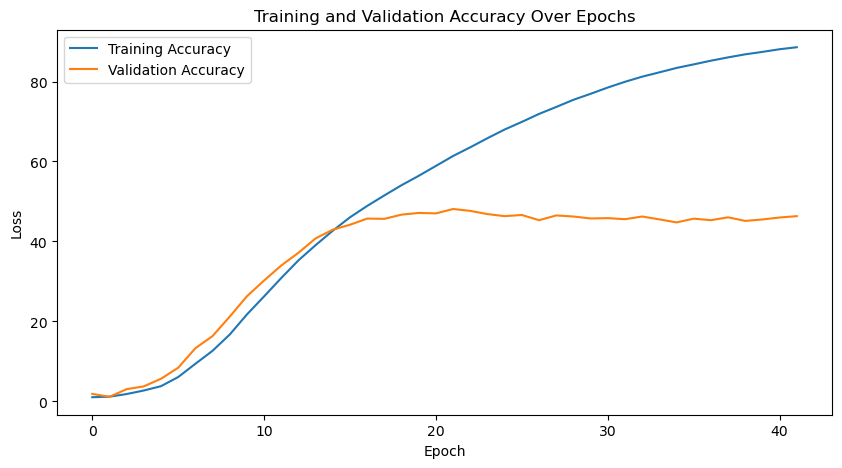

Extracting Embeddings: 100%|██████████| 35/35 [00:01<00:00, 21.98it/s]


Distance between embedding 3598 and 4362: 1.8423
Distance between embedding 3598 and 4001: 1.8114
Distance between embedding 3598 and 1356: 1.8742
Distance between embedding 3598 and 706: 1.3811
Distance between embedding 3598 and 2014: 2.0144
Distance between embedding 3598 and 60: 1.9895
Distance between embedding 3598 and 1771: 1.7217
Distance between embedding 3598 and 1131: 0.8507
Distance between embedding 3598 and 139: 1.4798
Distance between embedding 3598 and 64: 1.9431
Distance between embedding 3598 and 2672: 1.7551
Distance between embedding 3598 and 1817: 1.7210
Distance between embedding 3598 and 4101: 1.5383
Distance between embedding 3598 and 1530: 2.1604
Distance between embedding 3598 and 2575: 1.3860
Distance between embedding 3598 and 3503: 1.8364
Distance between embedding 3598 and 2497: 1.4359
Distance between embedding 3598 and 2089: 2.1679
Distance between embedding 3598 and 3176: 1.8114
Distance between embedding 4362 and 4001: 2.1390
Distance between embedding

Testing: 100%|██████████| 35/35 [00:01<00:00, 24.02it/s]


Test Accuracy: 48.12%
Test Precision: 0.49
Test Recall: 0.48
Test F1 Score: 0.48
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_1.pth
Finished training fold 1
Training fold 2/15...


Epoch 42/1000:   4%|▍         | 43/1000 [1:50:25<40:57:38, 154.08s/it, val_loss=8.39, val_contrastive=1.53, val_accuracy=42.9, train_loss=5.14, train_contrastive=1.94, best_accuracy=44.2, best_loss=8.39]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:02<00:00, 16.58it/s]


Test Accuracy: 44.16%
Test Precision: 0.45
Test Recall: 0.44
Test F1 Score: 0.43
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_2.pth
Finished training fold 2
Training fold 3/15...


Epoch 55/1000:   6%|▌         | 56/1000 [2:25:04<40:45:32, 155.44s/it, val_loss=8.36, val_contrastive=1.5, val_accuracy=42.7, train_loss=5.01, train_contrastive=1.9, best_accuracy=44.9, best_loss=8.36]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:02<00:00, 13.20it/s]


Test Accuracy: 44.87%
Test Precision: 0.45
Test Recall: 0.45
Test F1 Score: 0.44
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_3.pth
Finished training fold 3
Training fold 4/15...


Epoch 53/1000:   5%|▌         | 54/1000 [2:20:05<40:54:06, 155.65s/it, val_loss=8.56, val_contrastive=1.48, val_accuracy=40.3, train_loss=4.95, train_contrastive=1.86, best_accuracy=42.7, best_loss=8.52]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:02<00:00, 12.78it/s]


Test Accuracy: 42.68%
Test Precision: 0.43
Test Recall: 0.43
Test F1 Score: 0.42
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_4.pth
Finished training fold 4
Training fold 5/15...


Epoch 42/1000:   4%|▍         | 43/1000 [1:51:39<41:25:00, 155.80s/it, val_loss=8.19, val_contrastive=1.6, val_accuracy=45.7, train_loss=5.16, train_contrastive=1.96, best_accuracy=47, best_loss=8.19] 


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:02<00:00, 12.52it/s]


Test Accuracy: 47.02%
Test Precision: 0.49
Test Recall: 0.47
Test F1 Score: 0.47
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_5.pth
Finished training fold 5
Training fold 6/15...


Epoch 52/1000:   5%|▌         | 53/1000 [2:17:29<40:56:36, 155.65s/it, val_loss=8.72, val_contrastive=1.54, val_accuracy=40.5, train_loss=5.34, train_contrastive=1.94, best_accuracy=41.2, best_loss=8.69]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:02<00:00, 12.67it/s]


Test Accuracy: 41.25%
Test Precision: 0.43
Test Recall: 0.41
Test F1 Score: 0.40
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_6.pth
Finished training fold 6
Training fold 7/15...


Epoch 39/1000:   4%|▍         | 40/1000 [1:43:51<41:32:31, 155.78s/it, val_loss=8.19, val_contrastive=1.64, val_accuracy=46.9, train_loss=5.44, train_contrastive=1.99, best_accuracy=49.8, best_loss=8.19]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:02<00:00, 12.37it/s]
/usr/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 49.80%
Test Precision: 0.52
Test Recall: 0.50
Test F1 Score: 0.49
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_7.pth
Finished training fold 7
Training fold 8/15...


Epoch 49/1000:   5%|▌         | 50/1000 [2:10:10<41:13:15, 156.21s/it, val_loss=8.17, val_contrastive=1.52, val_accuracy=46.1, train_loss=4.92, train_contrastive=1.88, best_accuracy=47.6, best_loss=8.17]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:02<00:00, 11.87it/s]


Test Accuracy: 47.61%
Test Precision: 0.48
Test Recall: 0.48
Test F1 Score: 0.47
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_8.pth
Finished training fold 8
Training fold 9/15...


Epoch 45/1000:   5%|▍         | 46/1000 [1:59:48<41:24:38, 156.27s/it, val_loss=8.35, val_contrastive=1.61, val_accuracy=43.7, train_loss=5.45, train_contrastive=1.99, best_accuracy=44.5, best_loss=8.35]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:02<00:00, 12.02it/s]
/usr/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 44.52%
Test Precision: 0.46
Test Recall: 0.45
Test F1 Score: 0.44
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_9.pth
Finished training fold 9
Training fold 10/15...


Epoch 52/1000:   5%|▌         | 53/1000 [2:18:05<41:07:33, 156.34s/it, val_loss=8.59, val_contrastive=1.58, val_accuracy=40.3, train_loss=5.29, train_contrastive=1.94, best_accuracy=42.6, best_loss=8.57]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:02<00:00, 12.19it/s]


Test Accuracy: 42.64%
Test Precision: 0.44
Test Recall: 0.43
Test F1 Score: 0.42
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_10.pth
Finished training fold 10
Training fold 11/15...


Epoch 45/1000:   5%|▍         | 46/1000 [1:59:49<41:25:12, 156.30s/it, val_loss=8.46, val_contrastive=1.63, val_accuracy=42.3, train_loss=5.4, train_contrastive=1.99, best_accuracy=44.5, best_loss=8.42] 


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:02<00:00, 11.90it/s]


Test Accuracy: 44.52%
Test Precision: 0.46
Test Recall: 0.45
Test F1 Score: 0.44
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_11.pth
Finished training fold 11
Training fold 12/15...


Epoch 39/1000:   4%|▍         | 40/1000 [1:44:14<41:41:51, 156.37s/it, val_loss=8.15, val_contrastive=1.63, val_accuracy=45.1, train_loss=5.31, train_contrastive=1.98, best_accuracy=48.9, best_loss=8.15]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:02<00:00, 11.73it/s]


Test Accuracy: 48.90%
Test Precision: 0.51
Test Recall: 0.49
Test F1 Score: 0.48
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_12.pth
Finished training fold 12
Training fold 13/15...


Epoch 46/1000:   5%|▍         | 47/1000 [2:02:38<41:26:42, 156.56s/it, val_loss=8.33, val_contrastive=1.56, val_accuracy=42.1, train_loss=5.03, train_contrastive=1.92, best_accuracy=45.8, best_loss=8.32]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:03<00:00, 11.42it/s]


Test Accuracy: 45.77%
Test Precision: 0.47
Test Recall: 0.46
Test F1 Score: 0.45
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_13.pth
Finished training fold 13
Training fold 14/15...


Epoch 42/1000:   4%|▍         | 43/1000 [1:52:16<41:38:54, 156.67s/it, val_loss=8.01, val_contrastive=1.57, val_accuracy=46.4, train_loss=5.12, train_contrastive=1.95, best_accuracy=48.6, best_loss=8.01]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:03<00:00, 11.07it/s]


Test Accuracy: 48.61%
Test Precision: 0.50
Test Recall: 0.49
Test F1 Score: 0.48
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_14.pth
Finished training fold 14
Training fold 15/15...


Epoch 44/1000:   4%|▍         | 45/1000 [1:57:35<41:35:37, 156.79s/it, val_loss=8.71, val_contrastive=1.6, val_accuracy=41.8, train_loss=5.35, train_contrastive=1.97, best_accuracy=43.6, best_loss=8.66] 


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:03<00:00, 11.26it/s]


Test Accuracy: 43.58%
Test Precision: 0.45
Test Recall: 0.44
Test F1 Score: 0.42
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_15.pth
Finished training fold 15


Evaluating Noisy Samples: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


40.63579820317899% relabeling accuracy


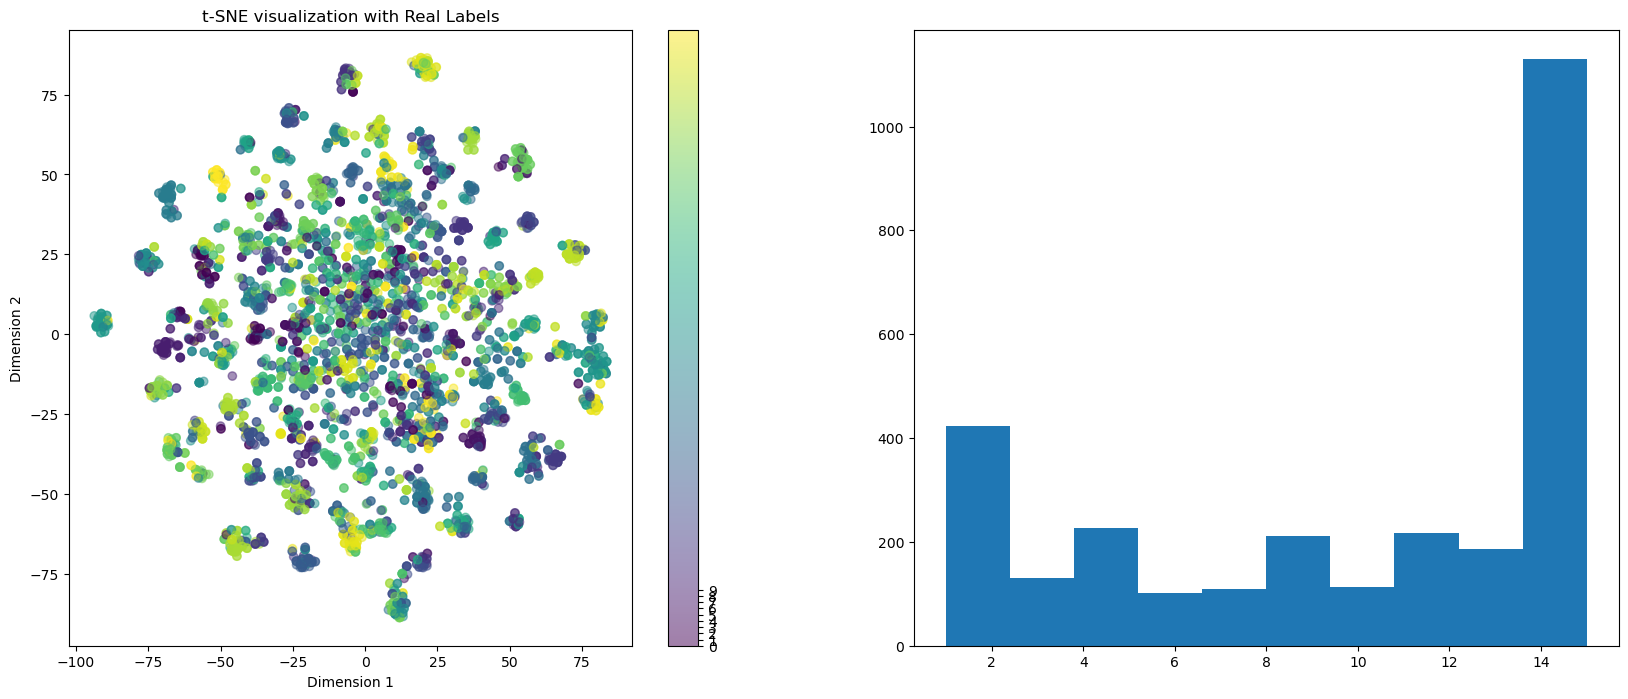

Predicted noise indices: [np.int64(109), np.int64(120), np.int64(138), np.int64(166), np.int64(171), np.int64(182), np.int64(267), np.int64(284), np.int64(350), np.int64(495), np.int64(498), np.int64(514), np.int64(536), np.int64(548), np.int64(575), np.int64(640), np.int64(650), np.int64(651), np.int64(671), np.int64(683), np.int64(694), np.int64(698), np.int64(707), np.int64(737), np.int64(860), np.int64(878), np.int64(911), np.int64(984), np.int64(1022), np.int64(1044), np.int64(1095), np.int64(1115), np.int64(1150), np.int64(1160), np.int64(1188), np.int64(1218), np.int64(1249), np.int64(1356), np.int64(1369), np.int64(1385), np.int64(1406), np.int64(1474), np.int64(1506), np.int64(1534), np.int64(1541), np.int64(1578), np.int64(1715), np.int64(1767), np.int64(1790), np.int64(1832), np.int64(1848), np.int64(1856), np.int64(1897), np.int64(1907), np.int64(1920), np.int64(1926), np.int64(1976), np.int64(1992), np.int64(2000), np.int64(2011), np.int64(2085), np.int64(2103), np.int64(2

Epoch 52/1000:   5%|▌         | 53/1000 [2:19:23<41:30:41, 157.81s/it, val_loss=8.4, val_contrastive=1.51, val_accuracy=43.2, train_loss=5.18, train_contrastive=1.92, best_accuracy=45.2, best_loss=8.39] 

Early stopping triggered
Loading best model from checkpoint...


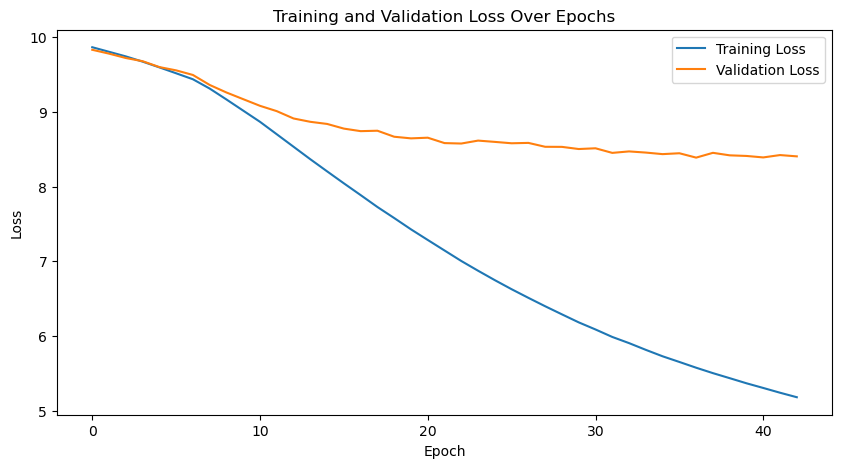

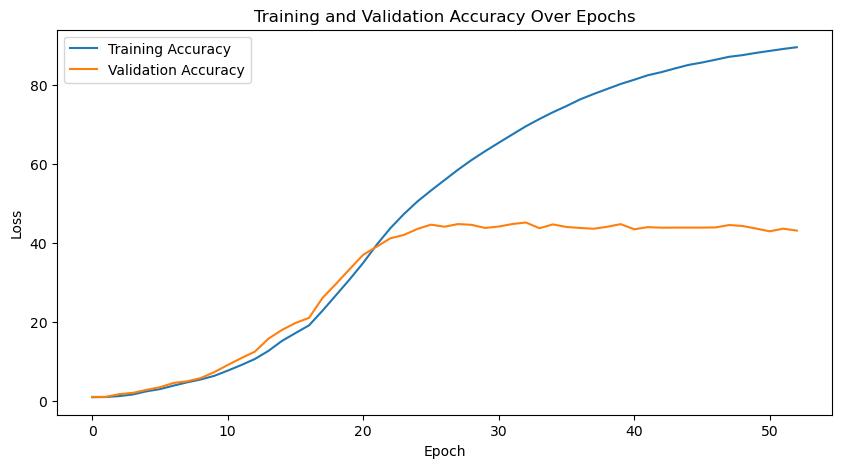

Extracting Embeddings: 100%|██████████| 35/35 [00:03<00:00,  9.18it/s]


Distance between embedding 2587 and 3218: 1.5044
Distance between embedding 2587 and 3987: 1.4201
Distance between embedding 2587 and 4025: 1.2218
Distance between embedding 2587 and 1857: 1.5077
Distance between embedding 2587 and 1502: 1.4798
Distance between embedding 2587 and 2144: 1.4444
Distance between embedding 2587 and 1969: 1.0812
Distance between embedding 2587 and 549: 1.4345
Distance between embedding 2587 and 1075: 1.6921
Distance between embedding 2587 and 3676: 1.4200
Distance between embedding 2587 and 3387: 1.4872
Distance between embedding 2587 and 4436: 1.0841
Distance between embedding 2587 and 3940: 1.2665
Distance between embedding 2587 and 1313: 1.1882
Distance between embedding 2587 and 81: 1.9859
Distance between embedding 2587 and 2072: 1.5257
Distance between embedding 2587 and 3694: 1.3799
Distance between embedding 2587 and 1318: 1.3411
Distance between embedding 2587 and 881: 1.2750
Distance between embedding 3218 and 3987: 1.8116
Distance between embeddi

Testing: 100%|██████████| 35/35 [00:03<00:00, 10.37it/s]


Test Accuracy: 45.21%
Test Precision: 0.47
Test Recall: 0.45
Test F1 Score: 0.45
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_1.pth
Finished training fold 1
Training fold 2/15...


Epoch 46/1000:   5%|▍         | 47/1000 [2:04:02<41:55:02, 158.34s/it, val_loss=8.69, val_contrastive=1.55, val_accuracy=40, train_loss=5.36, train_contrastive=1.97, best_accuracy=43.4, best_loss=8.69]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:03<00:00,  8.89it/s]


Test Accuracy: 43.38%
Test Precision: 0.46
Test Recall: 0.43
Test F1 Score: 0.43
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_2.pth
Finished training fold 2
Training fold 3/15...


Epoch 70/1000:   7%|▋         | 71/1000 [3:07:44<40:56:26, 158.65s/it, val_loss=8.48, val_contrastive=1.34, val_accuracy=41.3, train_loss=4.4, train_contrastive=1.69, best_accuracy=43, best_loss=8.45]   


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:04<00:00,  7.95it/s]


Test Accuracy: 42.99%
Test Precision: 0.44
Test Recall: 0.43
Test F1 Score: 0.43
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_3.pth
Finished training fold 3
Training fold 4/15...


Epoch 52/1000:   5%|▌         | 53/1000 [2:21:20<42:05:22, 160.00s/it, val_loss=8.27, val_contrastive=1.54, val_accuracy=44, train_loss=4.88, train_contrastive=1.9, best_accuracy=46.1, best_loss=8.25]   


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:04<00:00,  7.63it/s]


Test Accuracy: 46.08%
Test Precision: 0.47
Test Recall: 0.46
Test F1 Score: 0.46
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_4.pth
Finished training fold 4
Training fold 5/15...


Epoch 41/1000:   4%|▍         | 42/1000 [1:51:24<42:21:00, 159.14s/it, val_loss=8.11, val_contrastive=1.66, val_accuracy=48, train_loss=5.31, train_contrastive=1.98, best_accuracy=48.5, best_loss=8.11]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:04<00:00,  7.67it/s]


Test Accuracy: 48.50%
Test Precision: 0.50
Test Recall: 0.49
Test F1 Score: 0.48
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_5.pth
Finished training fold 5
Training fold 6/15...


Epoch 95/1000:  10%|▉         | 96/1000 [4:14:00<39:51:57, 158.76s/it, val_loss=8.7, val_contrastive=1.28, val_accuracy=38.8, train_loss=4.31, train_contrastive=1.57, best_accuracy=40.5, best_loss=8.63] 


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:04<00:00,  7.32it/s]


Test Accuracy: 40.49%
Test Precision: 0.43
Test Recall: 0.40
Test F1 Score: 0.41
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_6.pth
Finished training fold 6
Training fold 7/15...


Epoch 44/1000:   4%|▍         | 45/1000 [1:58:59<42:05:23, 158.66s/it, val_loss=8.28, val_contrastive=1.62, val_accuracy=44.9, train_loss=5.23, train_contrastive=1.96, best_accuracy=46.4, best_loss=8.28]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:04<00:00,  7.59it/s]


Test Accuracy: 46.40%
Test Precision: 0.48
Test Recall: 0.46
Test F1 Score: 0.46
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_7.pth
Finished training fold 7
Training fold 8/15...


Epoch 44/1000:   4%|▍         | 45/1000 [1:59:20<42:12:46, 159.13s/it, val_loss=8.24, val_contrastive=1.58, val_accuracy=42.7, train_loss=5.09, train_contrastive=1.93, best_accuracy=46.1, best_loss=8.21]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:04<00:00,  7.29it/s]
/usr/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 46.06%
Test Precision: 0.48
Test Recall: 0.46
Test F1 Score: 0.45
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_8.pth
Finished training fold 8
Training fold 9/15...


Epoch 38/1000:   4%|▍         | 39/1000 [1:43:44<42:36:25, 159.61s/it, val_loss=8.36, val_contrastive=1.61, val_accuracy=44.4, train_loss=5.33, train_contrastive=1.96, best_accuracy=47.1, best_loss=8.33]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:04<00:00,  7.26it/s]
/usr/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 47.09%
Test Precision: 0.47
Test Recall: 0.47
Test F1 Score: 0.46
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_9.pth
Finished training fold 9
Training fold 10/15...


Epoch 42/1000:   4%|▍         | 43/1000 [1:54:13<42:22:10, 159.38s/it, val_loss=8.17, val_contrastive=1.62, val_accuracy=45.9, train_loss=5.2, train_contrastive=1.96, best_accuracy=48.6, best_loss=8.17] 


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:04<00:00,  7.33it/s]
/usr/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 48.61%
Test Precision: 0.51
Test Recall: 0.49
Test F1 Score: 0.48
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_10.pth
Finished training fold 10
Training fold 11/15...


Epoch 39/1000:   4%|▍         | 40/1000 [1:46:42<42:41:11, 160.07s/it, val_loss=8.45, val_contrastive=1.66, val_accuracy=44.5, train_loss=5.51, train_contrastive=2, best_accuracy=46.6, best_loss=8.41]   


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:04<00:00,  7.09it/s]


Test Accuracy: 46.64%
Test Precision: 0.50
Test Recall: 0.47
Test F1 Score: 0.46
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_11.pth
Finished training fold 11
Training fold 12/15...


Epoch 43/1000:   4%|▍         | 44/1000 [1:57:17<42:28:23, 159.94s/it, val_loss=8.34, val_contrastive=1.66, val_accuracy=44.7, train_loss=5.44, train_contrastive=2.01, best_accuracy=46.3, best_loss=8.34]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:04<00:00,  7.57it/s]
/usr/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 46.26%
Test Precision: 0.51
Test Recall: 0.46
Test F1 Score: 0.45
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_12.pth
Finished training fold 12
Training fold 13/15...


Epoch 45/1000:   5%|▍         | 46/1000 [2:03:04<42:32:23, 160.53s/it, val_loss=8.54, val_contrastive=1.58, val_accuracy=43, train_loss=5.36, train_contrastive=1.98, best_accuracy=46.9, best_loss=8.53]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:04<00:00,  7.23it/s]


Test Accuracy: 46.93%
Test Precision: 0.48
Test Recall: 0.47
Test F1 Score: 0.46
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_13.pth
Finished training fold 13
Training fold 14/15...


Epoch 43/1000:   4%|▍         | 44/1000 [1:57:51<42:40:42, 160.71s/it, val_loss=8.45, val_contrastive=1.6, val_accuracy=43.4, train_loss=5.42, train_contrastive=1.98, best_accuracy=46.3, best_loss=8.4]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:04<00:00,  7.13it/s]


Test Accuracy: 46.33%
Test Precision: 0.46
Test Recall: 0.46
Test F1 Score: 0.45
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_14.pth
Finished training fold 14
Training fold 15/15...


Epoch 42/1000:   4%|▍         | 43/1000 [1:55:08<42:42:30, 160.66s/it, val_loss=8.38, val_contrastive=1.66, val_accuracy=44.3, train_loss=5.41, train_contrastive=1.95, best_accuracy=46.9, best_loss=8.35]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:05<00:00,  6.88it/s]
/usr/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 46.87%
Test Precision: 0.48
Test Recall: 0.47
Test F1 Score: 0.46
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_15.pth
Finished training fold 15


Evaluating Noisy Samples: 100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


42.35453315290933% relabeling accuracy


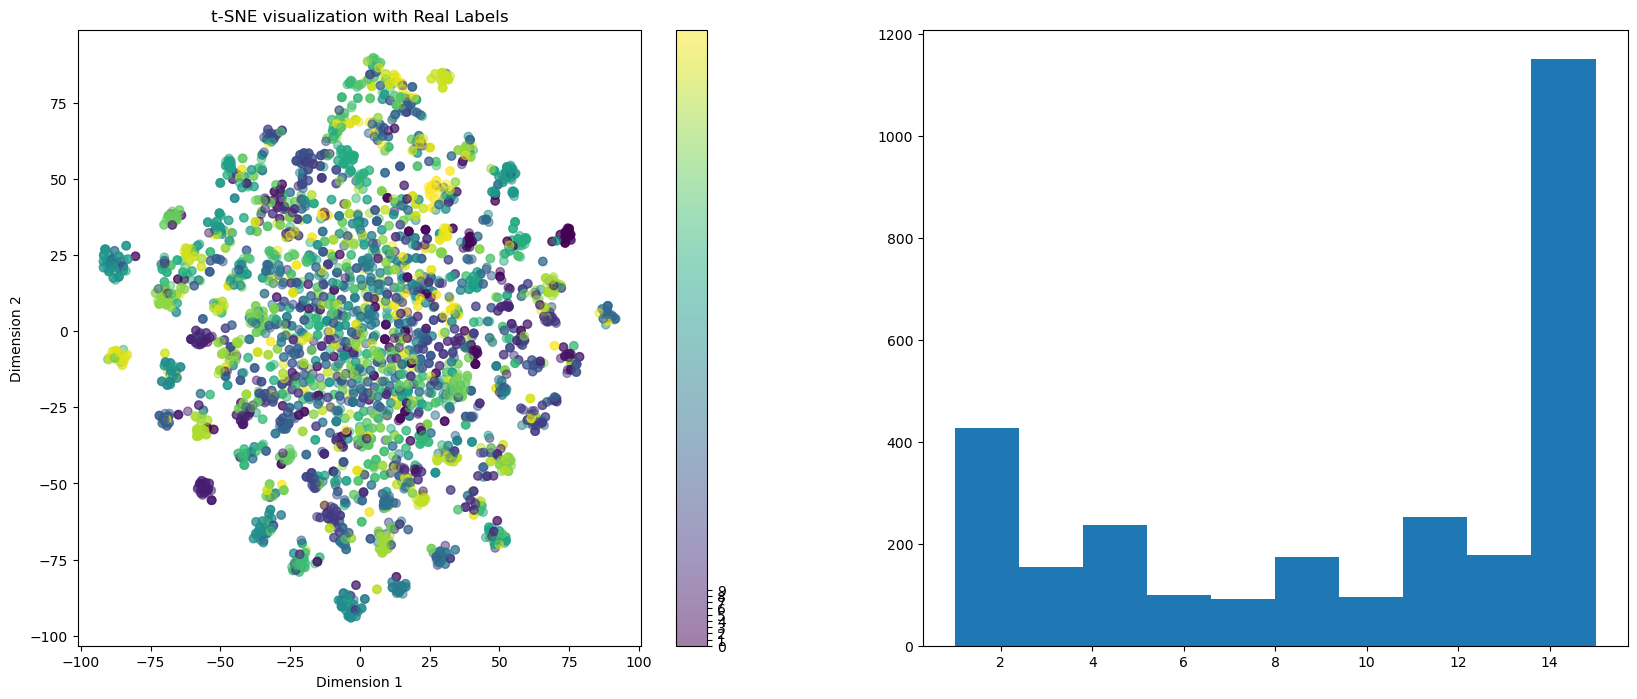

Predicted noise indices: [np.int64(0), np.int64(55), np.int64(56), np.int64(64), np.int64(65), np.int64(85), np.int64(131), np.int64(134), np.int64(146), np.int64(190), np.int64(194), np.int64(208), np.int64(239), np.int64(243), np.int64(261), np.int64(293), np.int64(301), np.int64(384), np.int64(409), np.int64(421), np.int64(428), np.int64(476), np.int64(497), np.int64(528), np.int64(537), np.int64(566), np.int64(620), np.int64(642), np.int64(661), np.int64(731), np.int64(757), np.int64(789), np.int64(802), np.int64(824), np.int64(870), np.int64(981), np.int64(1037), np.int64(1077), np.int64(1096), np.int64(1222), np.int64(1237), np.int64(1241), np.int64(1256), np.int64(1263), np.int64(1273), np.int64(1340), np.int64(1348), np.int64(1376), np.int64(1398), np.int64(1412), np.int64(1431), np.int64(1465), np.int64(1574), np.int64(1575), np.int64(1609), np.int64(1627), np.int64(1674), np.int64(1704), np.int64(1711), np.int64(1727), np.int64(1784), np.int64(1794), np.int64(1844), np.int64(

Epoch 45/1000:   5%|▍         | 46/1000 [2:04:13<42:56:19, 162.03s/it, val_loss=8.34, val_contrastive=1.58, val_accuracy=44.2, train_loss=5.13, train_contrastive=1.92, best_accuracy=46.2, best_loss=8.33]

Early stopping triggered
Loading best model from checkpoint...


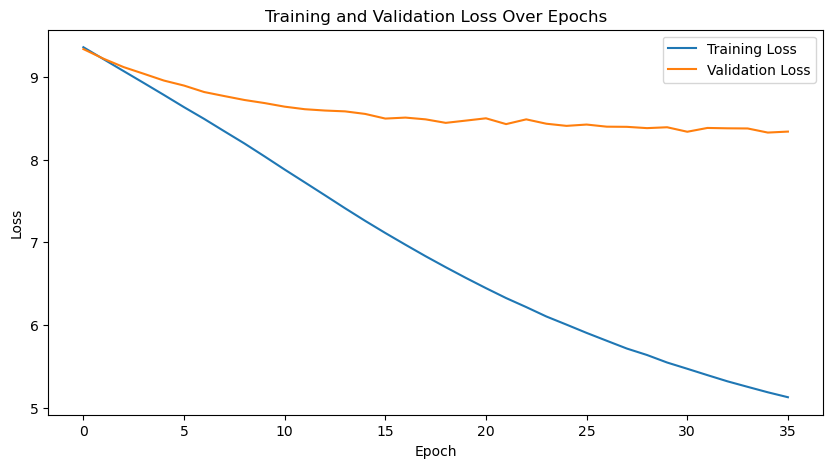

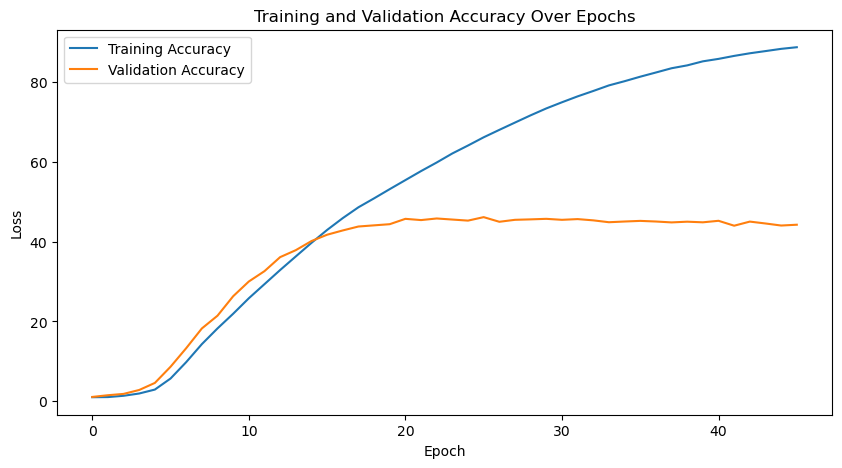

Extracting Embeddings: 100%|██████████| 35/35 [00:05<00:00,  6.21it/s]


Distance between embedding 3622 and 2489: 1.3079
Distance between embedding 3622 and 188: 1.9656
Distance between embedding 3622 and 276: 1.8553
Distance between embedding 3622 and 1660: 2.0612
Distance between embedding 3622 and 1798: 1.4788
Distance between embedding 3622 and 2329: 1.2577
Distance between embedding 3622 and 4319: 1.2947
Distance between embedding 3622 and 1723: 2.1085
Distance between embedding 3622 and 3192: 1.7434
Distance between embedding 3622 and 4428: 1.8929
Distance between embedding 3622 and 913: 1.4990
Distance between embedding 3622 and 1043: 1.8523
Distance between embedding 3622 and 3511: 1.5260
Distance between embedding 3622 and 2820: 1.4206
Distance between embedding 3622 and 2821: 1.7041
Distance between embedding 3622 and 1268: 1.4896
Distance between embedding 3622 and 1662: 1.2951
Distance between embedding 3622 and 4248: 1.6340
Distance between embedding 3622 and 1812: 1.6437
Distance between embedding 2489 and 188: 1.6549
Distance between embeddi

Testing: 100%|██████████| 35/35 [00:05<00:00,  6.55it/s]


Test Accuracy: 46.15%
Test Precision: 0.48
Test Recall: 0.46
Test F1 Score: 0.45
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_1.pth
Finished training fold 1
Training fold 2/15...


Epoch 64/1000:   6%|▋         | 65/1000 [2:56:37<42:20:43, 163.04s/it, val_loss=8.3, val_contrastive=1.42, val_accuracy=44, train_loss=4.55, train_contrastive=1.77, best_accuracy=45.1, best_loss=8.3]    


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:05<00:00,  6.05it/s]


Test Accuracy: 45.08%
Test Precision: 0.46
Test Recall: 0.45
Test F1 Score: 0.45
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_2.pth
Finished training fold 2
Training fold 3/15...


Epoch 42/1000:   4%|▍         | 43/1000 [1:57:52<43:43:30, 164.48s/it, val_loss=8.27, val_contrastive=1.59, val_accuracy=44.1, train_loss=5.19, train_contrastive=1.96, best_accuracy=48.1, best_loss=8.25]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:06<00:00,  5.56it/s]


Test Accuracy: 48.10%
Test Precision: 0.50
Test Recall: 0.48
Test F1 Score: 0.48
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_3.pth
Finished training fold 3
Training fold 4/15...


Epoch 85/1000:   9%|▊         | 86/1000 [3:55:54<41:47:15, 164.59s/it, val_loss=8.33, val_contrastive=1.27, val_accuracy=41.2, train_loss=4.01, train_contrastive=1.52, best_accuracy=43.4, best_loss=8.29]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:06<00:00,  5.59it/s]


Test Accuracy: 43.35%
Test Precision: 0.45
Test Recall: 0.43
Test F1 Score: 0.43
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_4.pth
Finished training fold 4
Training fold 5/15...


Epoch 42/1000:   4%|▍         | 43/1000 [1:57:28<43:34:24, 163.91s/it, val_loss=8.39, val_contrastive=1.6, val_accuracy=42.1, train_loss=5.4, train_contrastive=1.98, best_accuracy=46.2, best_loss=8.37]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:06<00:00,  5.28it/s]


Test Accuracy: 46.17%
Test Precision: 0.47
Test Recall: 0.46
Test F1 Score: 0.45
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_5.pth
Finished training fold 5
Training fold 6/15...


Epoch 42/1000:   4%|▍         | 43/1000 [1:56:58<43:23:18, 163.22s/it, val_loss=8.49, val_contrastive=1.66, val_accuracy=43.2, train_loss=5.56, train_contrastive=1.99, best_accuracy=45.1, best_loss=8.49]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:06<00:00,  5.45it/s]


Test Accuracy: 45.14%
Test Precision: 0.47
Test Recall: 0.45
Test F1 Score: 0.44
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_6.pth
Finished training fold 6
Training fold 7/15...


Epoch 38/1000:   4%|▍         | 39/1000 [1:45:52<43:28:46, 162.88s/it, val_loss=8.26, val_contrastive=1.57, val_accuracy=43.7, train_loss=5.32, train_contrastive=1.97, best_accuracy=48.6, best_loss=8.26]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:06<00:00,  5.66it/s]


Test Accuracy: 48.57%
Test Precision: 0.50
Test Recall: 0.49
Test F1 Score: 0.48
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_7.pth
Finished training fold 7
Training fold 8/15...


Epoch 49/1000:   5%|▌         | 50/1000 [2:16:24<43:11:44, 163.69s/it, val_loss=8.18, val_contrastive=1.5, val_accuracy=44.5, train_loss=4.82, train_contrastive=1.86, best_accuracy=46.5, best_loss=8.16] 


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:06<00:00,  5.10it/s]


Test Accuracy: 46.51%
Test Precision: 0.47
Test Recall: 0.47
Test F1 Score: 0.46
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_8.pth
Finished training fold 8
Training fold 9/15...


Epoch 47/1000:   5%|▍         | 48/1000 [2:10:47<43:13:57, 163.49s/it, val_loss=8.41, val_contrastive=1.63, val_accuracy=44, train_loss=5.48, train_contrastive=2, best_accuracy=45.1, best_loss=8.39]     


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:06<00:00,  5.48it/s]


Test Accuracy: 45.10%
Test Precision: 0.47
Test Recall: 0.45
Test F1 Score: 0.44
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_9.pth
Finished training fold 9
Training fold 10/15...


Epoch 48/1000:   5%|▍         | 49/1000 [2:13:49<43:17:24, 163.87s/it, val_loss=8.15, val_contrastive=1.55, val_accuracy=45.1, train_loss=4.9, train_contrastive=1.89, best_accuracy=48.1, best_loss=8.15] 


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:06<00:00,  5.35it/s]


Test Accuracy: 48.10%
Test Precision: 0.49
Test Recall: 0.48
Test F1 Score: 0.47
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_10.pth
Finished training fold 10
Training fold 11/15...


Epoch 44/1000:   4%|▍         | 45/1000 [2:02:44<43:25:00, 163.67s/it, val_loss=8.59, val_contrastive=1.56, val_accuracy=41, train_loss=5.45, train_contrastive=1.97, best_accuracy=42.9, best_loss=8.59]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:06<00:00,  5.43it/s]


Test Accuracy: 42.88%
Test Precision: 0.44
Test Recall: 0.43
Test F1 Score: 0.41
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_11.pth
Finished training fold 11
Training fold 12/15...


Epoch 40/1000:   4%|▍         | 41/1000 [1:52:00<43:39:49, 163.91s/it, val_loss=8.17, val_contrastive=1.59, val_accuracy=44.5, train_loss=5.22, train_contrastive=1.96, best_accuracy=48.1, best_loss=8.14]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:06<00:00,  5.64it/s]


Test Accuracy: 48.08%
Test Precision: 0.49
Test Recall: 0.48
Test F1 Score: 0.47
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_12.pth
Finished training fold 12
Training fold 13/15...


Epoch 43/1000:   4%|▍         | 44/1000 [2:00:33<43:39:23, 164.40s/it, val_loss=8.45, val_contrastive=1.63, val_accuracy=43.8, train_loss=5.33, train_contrastive=1.98, best_accuracy=47, best_loss=8.45]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:06<00:00,  5.39it/s]


Test Accuracy: 47.00%
Test Precision: 0.49
Test Recall: 0.47
Test F1 Score: 0.47
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_13.pth
Finished training fold 13
Training fold 14/15...


Epoch 42/1000:   4%|▍         | 43/1000 [1:57:55<43:44:28, 164.54s/it, val_loss=8.22, val_contrastive=1.55, val_accuracy=44.3, train_loss=5.11, train_contrastive=1.94, best_accuracy=46.8, best_loss=8.22]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:06<00:00,  5.01it/s]


Test Accuracy: 46.84%
Test Precision: 0.49
Test Recall: 0.47
Test F1 Score: 0.46
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_14.pth
Finished training fold 14
Training fold 15/15...


Epoch 53/1000:   5%|▌         | 54/1000 [2:28:10<43:15:41, 164.63s/it, val_loss=8.09, val_contrastive=1.5, val_accuracy=44.6, train_loss=4.83, train_contrastive=1.87, best_accuracy=46.7, best_loss=8.09] 


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:06<00:00,  5.30it/s]


Test Accuracy: 46.73%
Test Precision: 0.48
Test Recall: 0.47
Test F1 Score: 0.46
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_15.pth
Finished training fold 15


Evaluating Noisy Samples: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


42.13091922005571% relabeling accuracy


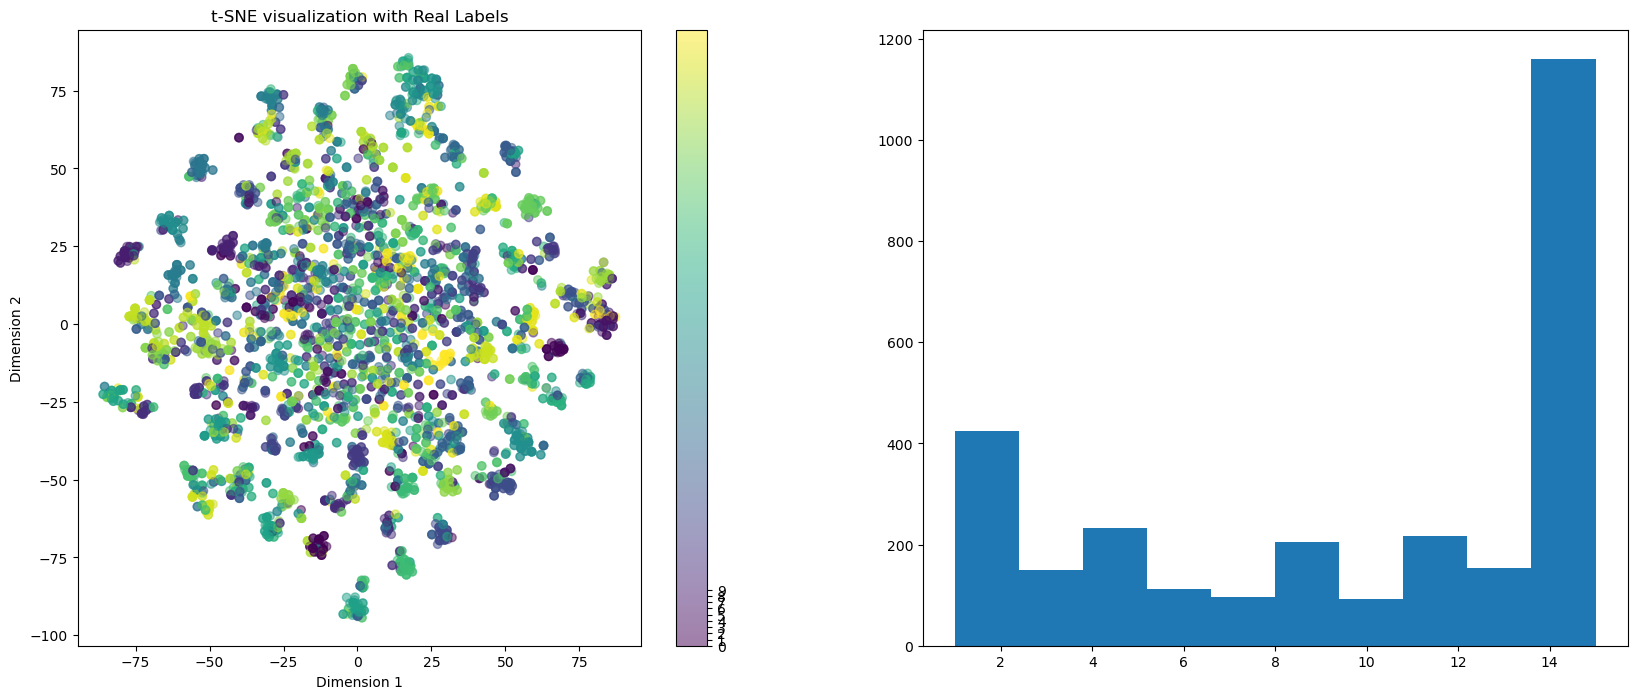

Predicted noise indices: [np.int64(46), np.int64(80), np.int64(86), np.int64(128), np.int64(212), np.int64(233), np.int64(290), np.int64(295), np.int64(322), np.int64(335), np.int64(373), np.int64(387), np.int64(401), np.int64(434), np.int64(503), np.int64(554), np.int64(598), np.int64(669), np.int64(687), np.int64(691), np.int64(696), np.int64(727), np.int64(784), np.int64(800), np.int64(801), np.int64(814), np.int64(822), np.int64(868), np.int64(898), np.int64(944), np.int64(946), np.int64(950), np.int64(963), np.int64(1004), np.int64(1021), np.int64(1036), np.int64(1056), np.int64(1057), np.int64(1079), np.int64(1123), np.int64(1285), np.int64(1321), np.int64(1360), np.int64(1371), np.int64(1414), np.int64(1442), np.int64(1453), np.int64(1520), np.int64(1533), np.int64(1535), np.int64(1553), np.int64(1561), np.int64(1579), np.int64(1601), np.int64(1603), np.int64(1631), np.int64(1720), np.int64(1748), np.int64(1757), np.int64(1771), np.int64(1787), np.int64(1791), np.int64(1797), np

Epoch 91/1000:   9%|▉         | 92/1000 [4:15:30<42:01:41, 166.63s/it, val_loss=8.11, val_contrastive=1.27, val_accuracy=42, train_loss=3.97, train_contrastive=1.5, best_accuracy=43.5, best_loss=8.11]   

Early stopping triggered
Loading best model from checkpoint...


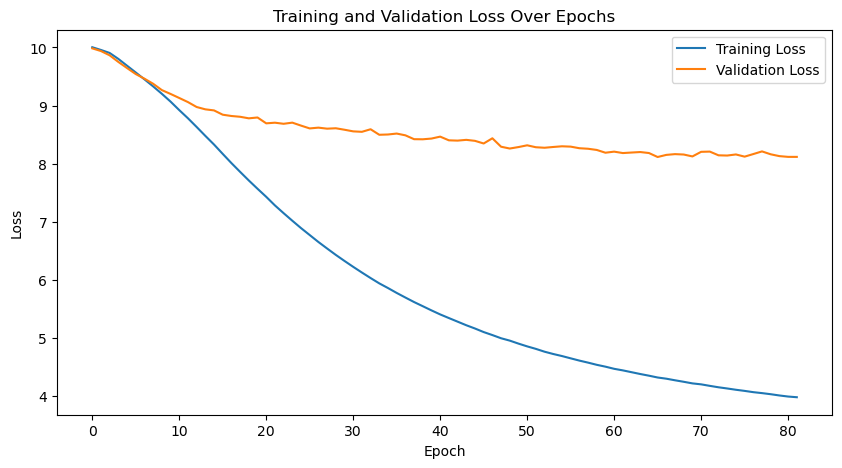

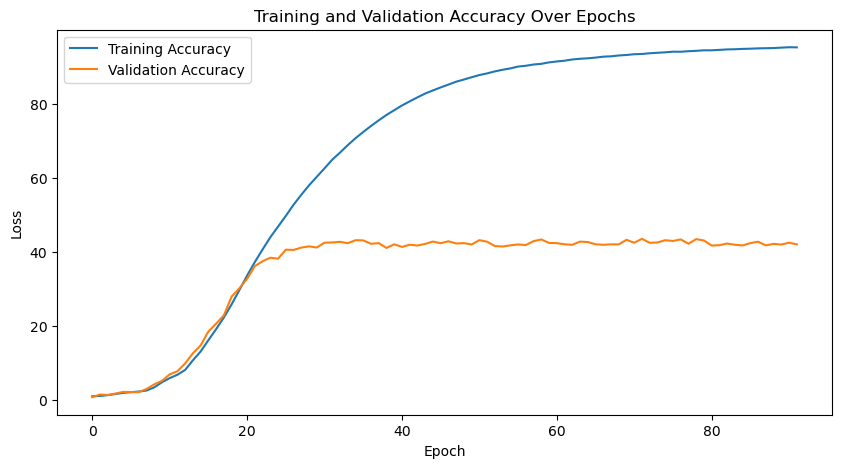

Extracting Embeddings: 100%|██████████| 35/35 [00:07<00:00,  4.77it/s]


Distance between embedding 49 and 1240: 1.7400
Distance between embedding 49 and 1619: 1.4433
Distance between embedding 49 and 706: 1.7628
Distance between embedding 49 and 2852: 1.6600
Distance between embedding 49 and 134: 1.5961
Distance between embedding 49 and 3645: 1.8196
Distance between embedding 49 and 2406: 1.8280
Distance between embedding 49 and 1694: 1.3886
Distance between embedding 49 and 3275: 1.5887
Distance between embedding 49 and 518: 1.2281
Distance between embedding 49 and 1912: 1.5366
Distance between embedding 49 and 4424: 1.5790
Distance between embedding 49 and 159: 1.7151
Distance between embedding 49 and 1389: 1.4014
Distance between embedding 49 and 3819: 1.5308
Distance between embedding 49 and 220: 1.3170
Distance between embedding 49 and 282: 1.4898
Distance between embedding 49 and 3862: 1.9768
Distance between embedding 49 and 2358: 1.7132
Distance between embedding 1240 and 1619: 1.3454
Distance between embedding 1240 and 706: 1.2724
Distance between

Testing: 100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


Test Accuracy: 43.53%
Test Precision: 0.45
Test Recall: 0.44
Test F1 Score: 0.44
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_1.pth
Finished training fold 1
Training fold 2/15...


Epoch 85/1000:   9%|▊         | 86/1000 [4:00:13<42:33:09, 167.60s/it, val_loss=8.14, val_contrastive=1.26, val_accuracy=44, train_loss=3.98, train_contrastive=1.51, best_accuracy=45.1, best_loss=8.11]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:08<00:00,  4.26it/s]


Test Accuracy: 45.05%
Test Precision: 0.45
Test Recall: 0.45
Test F1 Score: 0.45
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_2.pth
Finished training fold 2
Training fold 3/15...


Epoch 41/1000:   4%|▍         | 42/1000 [1:58:08<44:54:50, 168.78s/it, val_loss=8.35, val_contrastive=1.6, val_accuracy=45.2, train_loss=5.34, train_contrastive=1.97, best_accuracy=46.4, best_loss=8.35] 


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 35/35 [00:08<00:00,  4.06it/s]


Test Accuracy: 46.35%
Test Precision: 0.48
Test Recall: 0.46
Test F1 Score: 0.45
Model saved to cifar100(20)/resnet50/model_resnet50_cifar10_fold_3.pth
Finished training fold 3
Training fold 4/15...


Epoch 20/1000:   2%|▏         | 20/1000 [56:27<46:00:29, 169.01s/it, val_loss=8.96, val_contrastive=1.63, val_accuracy=40.3, train_loss=8.74, train_contrastive=1.5, best_accuracy=40.3, best_loss=8.96] 

In [ ]:
noise_cleaner.clean()